# Analyzing Weekly Spending Patterns: Identifying Cycles in Personal Daily Expenses

In [659]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd

plt.rcParams["figure.figsize"] = (12, 5)

# Load Data

In [660]:
BASE_DIR = "/content/"
EXPENSES_PATH = os.path.join(BASE_DIR, "Total_Expenses.csv")
INCOME_PATH   = os.path.join(BASE_DIR, "Total_Income.csv")

df_expenses = pd.read_csv(EXPENSES_PATH)
df_income   = pd.read_csv(INCOME_PATH)

print("Expenses shape:", df_expenses.shape)
print("Income shape:", df_income.shape)

Expenses shape: (1204, 5)
Income shape: (312, 4)


In [661]:
print("Expenses head:")
display(df_expenses.head())

Expenses head:


,Expenses_Date,Expenses_Amount,Expenses_Description,Expenses_Category,Day_Type
0,01/09/2024,839.00,First Week Grocery,Grocery,Weekend
1,01/09/2024,430.00,Macao + Popeyes + Uncle J,Food,Weekend
2,01/09/2024,20.00,Transpo,Transportation,Weekend
3,01/09/2024,764.00,Chairs + Rack,Personal,Weekend
4,01/09/2024,135.00,Basahan + DustPan&Walis,Personal,Weekend


In [662]:
print("\nIncome head:")
display(df_income.head())


Income head:


,Income_Date,Income_Amount,Income_Description,Income_Category
0,01/09/2024,"2,000.00",Allowance,School Allowance
1,01/09/2024,"1,500.00",Allowance,Food Allowance
2,01/09/2024,500.00,Chair,Other
3,03/09/2024,"2,000.00",Allowance,Scholarship Allowance
4,07/09/2024,"5,000.00",For Keeps,Scholarship Allowance


# Data Cleaning and Preparation

In [663]:
def df_check(df: pd.DataFrame, name: str):
    print("\n" + "="*80)
    print(f"DATAFRAME CHECK: {name}")
    print("="*80)

    print("Shape:", df.shape)

    print("\nDtypes:")
    display(df.dtypes)

    print("\nMissing values per column:")
    display(df.isna().sum().sort_values(ascending=False))

    # Count duplicates
    dup_count = df.duplicated().sum()
    print("\nDuplicate rows (exact matches):", dup_count)

    if dup_count > 0:
        print("\nShowing duplicated rows:")
        display(df[df.duplicated()])

        print("\nShowing ALL occurrences of duplicated rows:")
        display(df[df.duplicated(keep=False)])
    else:
        print("No duplicate rows found.")

    print("\nUnique values per column:")
    display(df.nunique().sort_values(ascending=False))

    print("\nSummary statistics:")
    display(df.describe(include="all"))

    print("\nPreview:")
    display(df.head(10))

    print("\nDataFrame Info:")
    df.info()

In [664]:
df_check(df_expenses, "Expenses")


DATAFRAME CHECK: Expenses
Shape: (1204, 5)

Dtypes:


,0
Expenses_Date,object
Expenses_Amount,object
Expenses_Description,object
Expenses_Category,object
Day_Type,object



Missing values per column:


,0
Expenses_Description,2
Expenses_Date,0
Expenses_Amount,0
Expenses_Category,0
Day_Type,0



Duplicate rows (exact matches): 1

Showing duplicated rows:


,Expenses_Date,Expenses_Amount,Expenses_Description,Expenses_Category,Day_Type
497,01/04/2025,50.00,Food,Week 1 (1-5),School



Showing ALL occurrences of duplicated rows:


,Expenses_Date,Expenses_Amount,Expenses_Description,Expenses_Category,Day_Type
488,01/04/2025,50.00,Food,Week 1 (1-5),School
497,01/04/2025,50.00,Food,Week 1 (1-5),School



Unique values per column:


,0
Expenses_Date,473
Expenses_Amount,426
Expenses_Description,323
Expenses_Category,75
Day_Type,3



Summary statistics:


,Expenses_Date,Expenses_Amount,Expenses_Description,Expenses_Category,Day_Type
count,1204,1204,1202,1204,1204
unique,473,426,323,75,3
top,01/04/2025,200.00,Food,Transportation,School
freq,16,65,357,272,577



Preview:


,Expenses_Date,Expenses_Amount,Expenses_Description,Expenses_Category,Day_Type
0,01/09/2024,839.00,First Week Grocery,Grocery,Weekend
1,01/09/2024,430.00,Macao + Popeyes + Uncle J,Food,Weekend
2,01/09/2024,20.00,Transpo,Transportation,Weekend
3,01/09/2024,764.00,Chairs + Rack,Personal,Weekend
4,01/09/2024,135.00,Basahan + DustPan&Walis,Personal,Weekend
5,01/09/2024,46.00,Scissor + Cutter,Personal,Weekend
6,02/09/2024,203.00,Food,Food,School
7,02/09/2024,423.00,Dish Rack,Personal,School
8,02/09/2024,375.00,Water + Ref,Personal,School
9,03/09/2024,349.00,Food,Food,School



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1204 entries, 0 to 1203
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Expenses_Date         1204 non-null   object
 1   Expenses_Amount       1204 non-null   object
 2   Expenses_Description  1202 non-null   object
 3   Expenses_Category     1204 non-null   object
 4   Day_Type              1204 non-null   object
dtypes: object(5)
memory usage: 47.2+ KB


In [665]:
df_check(df_income, "Income")


DATAFRAME CHECK: Income
Shape: (312, 4)

Dtypes:


,0
Income_Date,object
Income_Amount,object
Income_Description,object
Income_Category,object



Missing values per column:


,0
Income_Description,2
Income_Date,0
Income_Amount,0
Income_Category,0



Duplicate rows (exact matches): 0
No duplicate rows found.

Unique values per column:


,0
Income_Date,203
Income_Description,96
Income_Amount,69
Income_Category,11



Summary statistics:


,Income_Date,Income_Amount,Income_Description,Income_Category
count,312,312,310,312
unique,203,69,96,11
top,01/12/2024,500.00,Allowance,Others
freq,5,52,91,102



Preview:


,Income_Date,Income_Amount,Income_Description,Income_Category
0,01/09/2024,"2,000.00",Allowance,School Allowance
1,01/09/2024,"1,500.00",Allowance,Food Allowance
2,01/09/2024,500.00,Chair,Other
3,03/09/2024,"2,000.00",Allowance,Scholarship Allowance
4,07/09/2024,"5,000.00",For Keeps,Scholarship Allowance
5,08/09/2024,200.00,Transpo,Transpo Allowance
6,10/09/2024,500.00,Meralco Load,Utility Allowance
7,10/09/2024,200.00,For contest,School Allowance
8,10/09/2024,"1,000.00",Allowance,Scholarship Allowance
9,13/09/2024,"1,500.00",Allowance,Scholarship Allowance



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Income_Date         312 non-null    object
 1   Income_Amount       312 non-null    object
 2   Income_Description  310 non-null    object
 3   Income_Category     312 non-null    object
dtypes: object(4)
memory usage: 9.9+ KB


In [666]:
# PARSE DATES (DD-MM-YYYY) + BASIC CLEANING
def parse_date_series(s: pd.Series, colname: str):
    parsed = pd.to_datetime(s, format="%d/%m/%Y", errors="coerce")
    bad = parsed.isna().sum()
    if bad > 0:
        print(f"[WARNING] {bad} invalid date(s) found in {colname} (set to NaT).")
    return parsed

df_expenses["Expenses_Date"] = parse_date_series(df_expenses["Expenses_Date"], "Expenses_Date")
df_income["Income_Date"]     = parse_date_series(df_income["Income_Date"], "Income_Date")

In [667]:
# Drop invalid/missing dates
df_expenses = df_expenses.dropna(subset=["Expenses_Date"]).copy()
df_income   = df_income.dropna(subset=["Income_Date"]).copy()

In [668]:
# Trim strings
for c in ["Expenses_Description", "Expenses_Category", "Day_Type"]:
    if c in df_expenses.columns:
        df_expenses[c] = df_expenses[c].astype(str).str.strip()

for c in ["Income_Description", "Income_Category"]:
    if c in df_income.columns:
        df_income[c] = df_income[c].astype(str).str.strip()

In [669]:
# Amount to numeric
df_expenses['Expenses_Amount'] = (
    df_expenses['Expenses_Amount']
    .astype(str) # Ensure it's string before replace
    .str.replace(',', '', regex=False) # Remove commas
    .pipe(pd.to_numeric, errors='coerce') # Convert to float, coercing errors to NaN
)

df_income['Income_Amount'] = (
    df_income['Income_Amount']
    .astype(str) # Ensure it's string before replace
    .str.replace(',', '', regex=False) # Remove commas
    .pipe(pd.to_numeric, errors='coerce') # Convert to float, coercing errors to NaN
)

print("Missing amounts (expenses):", df_expenses["Expenses_Amount"].isna().sum())
print("Missing amounts (income):", df_income["Income_Amount"].isna().sum())

Missing amounts (expenses): 0
Missing amounts (income): 0


In [670]:
# Keep Day_Type as manually entered — just validate
if "Day_Type" in df_expenses.columns:
    df_expenses["Day_Type"] = df_expenses["Day_Type"].astype(str).str.strip()
    valid = {"School", "Regular", "Weekend"}
    bad_daytype = df_expenses.loc[~df_expenses["Day_Type"].isin(valid) & df_expenses["Day_Type"].notna(), "Day_Type"].unique()
    print("Invalid Day_Type labels:", bad_daytype)

Invalid Day_Type labels: []


In [671]:
# Drop invalid date/amount rows (document counts)
before = len(df_expenses)
df_expenses = df_expenses.dropna(subset=['Expenses_Date', 'Expenses_Amount'])
print("Dropped rows (missing date/amount):", before - len(df_expenses))

Dropped rows (missing date/amount): 0


In [672]:
# Drop duplicates
df_check(df_expenses, "Expenses (cleaned)")


DATAFRAME CHECK: Expenses (cleaned)
Shape: (1204, 5)

Dtypes:


,0
Expenses_Date,datetime64[ns]
Expenses_Amount,float64
Expenses_Description,object
Expenses_Category,object
Day_Type,object



Missing values per column:


,0
Expenses_Date,0
Expenses_Amount,0
Expenses_Description,0
Expenses_Category,0
Day_Type,0



Duplicate rows (exact matches): 1

Showing duplicated rows:


,Expenses_Date,Expenses_Amount,Expenses_Description,Expenses_Category,Day_Type
497,2025-04-01,50.0,Food,Week 1 (1-5),School



Showing ALL occurrences of duplicated rows:


,Expenses_Date,Expenses_Amount,Expenses_Description,Expenses_Category,Day_Type
488,2025-04-01,50.0,Food,Week 1 (1-5),School
497,2025-04-01,50.0,Food,Week 1 (1-5),School



Unique values per column:


,0
Expenses_Date,471
Expenses_Amount,426
Expenses_Description,301
Expenses_Category,74
Day_Type,3



Summary statistics:


,Expenses_Date,Expenses_Amount,Expenses_Description,Expenses_Category,Day_Type
count,1204,1204.000000,1204,1204,1204
unique,NaN,NaN,301,74,3
top,NaN,NaN,Food,Transportation,School
freq,NaN,NaN,366,272,577
mean,2025-05-21 23:28:54.219269120,443.469269,NaN,NaN,NaN
min,2024-09-01 00:00:00,10.000000,NaN,NaN,NaN
25%,2025-01-12 18:00:00,100.000000,NaN,NaN,NaN
50%,2025-05-18 12:00:00,200.000000,NaN,NaN,NaN
75%,2025-10-01 00:00:00,398.250000,NaN,NaN,NaN
max,2026-02-07 00:00:00,10000.000000,NaN,NaN,NaN



Preview:


,Expenses_Date,Expenses_Amount,Expenses_Description,Expenses_Category,Day_Type
0,2024-09-01,839.0,First Week Grocery,Grocery,Weekend
1,2024-09-01,430.0,Macao + Popeyes + Uncle J,Food,Weekend
2,2024-09-01,20.0,Transpo,Transportation,Weekend
3,2024-09-01,764.0,Chairs + Rack,Personal,Weekend
4,2024-09-01,135.0,Basahan + DustPan&Walis,Personal,Weekend
5,2024-09-01,46.0,Scissor + Cutter,Personal,Weekend
6,2024-09-02,203.0,Food,Food,School
7,2024-09-02,423.0,Dish Rack,Personal,School
8,2024-09-02,375.0,Water + Ref,Personal,School
9,2024-09-03,349.0,Food,Food,School



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1204 entries, 0 to 1203
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Expenses_Date         1204 non-null   datetime64[ns]
 1   Expenses_Amount       1204 non-null   float64       
 2   Expenses_Description  1204 non-null   object        
 3   Expenses_Category     1204 non-null   object        
 4   Day_Type              1204 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 47.2+ KB


In [673]:
df_check(df_income, "Income (cleaned)")


DATAFRAME CHECK: Income (cleaned)
Shape: (312, 4)

Dtypes:


,0
Income_Date,datetime64[ns]
Income_Amount,float64
Income_Description,object
Income_Category,object



Missing values per column:


,0
Income_Date,0
Income_Amount,0
Income_Description,0
Income_Category,0



Duplicate rows (exact matches): 0
No duplicate rows found.

Unique values per column:


,0
Income_Date,203
Income_Description,88
Income_Amount,69
Income_Category,10



Summary statistics:


,Income_Date,Income_Amount,Income_Description,Income_Category
count,312,312.000000,312,312
unique,NaN,NaN,88,10
top,NaN,NaN,Allowance,Others
freq,NaN,NaN,132,102
mean,2025-05-07 17:04:36.923076864,1773.807692,NaN,NaN
min,2024-09-01 00:00:00,9.000000,NaN,NaN
25%,2024-12-27 12:00:00,500.000000,NaN,NaN
50%,2025-04-29 00:00:00,1000.000000,NaN,NaN
75%,2025-09-11 06:00:00,2500.000000,NaN,NaN
max,2026-02-07 00:00:00,21000.000000,NaN,NaN



Preview:


,Income_Date,Income_Amount,Income_Description,Income_Category
0,2024-09-01,2000.0,Allowance,School Allowance
1,2024-09-01,1500.0,Allowance,Food Allowance
2,2024-09-01,500.0,Chair,Other
3,2024-09-03,2000.0,Allowance,Scholarship Allowance
4,2024-09-07,5000.0,For Keeps,Scholarship Allowance
5,2024-09-08,200.0,Transpo,Transpo Allowance
6,2024-09-10,500.0,Meralco Load,Utility Allowance
7,2024-09-10,200.0,For contest,School Allowance
8,2024-09-10,1000.0,Allowance,Scholarship Allowance
9,2024-09-13,1500.0,Allowance,Scholarship Allowance



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Income_Date         312 non-null    datetime64[ns]
 1   Income_Amount       312 non-null    float64       
 2   Income_Description  312 non-null    object        
 3   Income_Category     312 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 9.9+ KB


In [674]:
df_expenses.describe()

,Expenses_Date,Expenses_Amount
count,1204,1204.000000
mean,2025-05-21 23:28:54.219269120,443.469269
min,2024-09-01 00:00:00,10.000000
25%,2025-01-12 18:00:00,100.000000
50%,2025-05-18 12:00:00,200.000000
75%,2025-10-01 00:00:00,398.250000
max,2026-02-07 00:00:00,10000.000000
std,NaN,1020.129975


In [675]:
df_income.describe()

,Income_Date,Income_Amount
count,312,312.000000
mean,2025-05-07 17:04:36.923076864,1773.807692
min,2024-09-01 00:00:00,9.000000
25%,2024-12-27 12:00:00,500.000000
50%,2025-04-29 00:00:00,1000.000000
75%,2025-09-11 06:00:00,2500.000000
max,2026-02-07 00:00:00,21000.000000
std,NaN,2340.003000


In [676]:
df_expenses['Expenses_Category'].unique()

array(['Grocery', 'Food', 'Transportation', 'Personal', 'Patago',
       'Laundry', 'School', 'Power bill', 'Birthday', 'Tuition Payment',
       'Week 1 (1-5)', 'Water Bill', 'Oct Rent', 'Week 2 (6-12)',
       'Internet Bill', 'Week 3 (13-19)', 'Week 4 (20-26)', 'Power Bill',
       'Week 5 (27-2)', 'Nov Rent', 'Week 1 (3-9)', 'Week 2 (10-16)',
       'Week 3 (17-23)', 'Week 4 (25-30)', 'Dec Rent', 'Week 1 (1-7)',
       'Week 2 (8-14)', 'Week 3 (15-21)', 'Birthday Celeb',
       'Week 1 (5-11)', 'Jan Rent', 'Tuition', 'Week 2 (5-18)',
       'Week 3 (19-25)', 'Week 4 (26-31)', 'Week 1 (2-8)', 'Feb Rent',
       'Week 2 (9-15)', 'Week 3 (16-22)', 'Week 4 (23-28)', 'Mar Rent',
       'Swimming', 'Week 4 (23-31)', 'Apr Rent', 'Week 4 (20-30)',
       'Week 1 (1-10)', 'Week 2 (12-17)', 'Week 3 (18-24)',
       'Week 4 (25-31)', 'Week 4 (22-30)', 'June Rent', 'July Rent',
       'Week 5 (27-31)', 'Gym', 'Aug Rent', 'Week 1 (1-9)',
       'Week 4 (24-31)', 'Week 1 (1-6)', 'August Rent', '

In [677]:
df_expenses.loc[
    df_expenses['Expenses_Category'].str.contains('Rent', na=False),
    'Expenses_Category'
] = 'Rent'

In [678]:
df_expenses.loc[
    df_expenses['Expenses_Category'].str.contains('Week', na=False),
    'Expenses_Category'
] = 'Food'

In [679]:
df_expenses.loc[
    df_expenses['Expenses_Category'].str.contains('Bill|bill|Laundry', na=False),
    'Expenses_Category'
] = 'Utilities'

In [680]:
df_expenses.loc[
    df_expenses['Expenses_Category'].str.contains('Birthday|Swimming|Gym|Grocery', na=False),
    'Expenses_Category'
] = 'Personal'

In [681]:
df_expenses.loc[
    df_expenses['Expenses_Category'].str.contains('Tuition', na=False),
    'Expenses_Category'
] = 'School'

In [682]:
df_expenses.loc[
    df_expenses['Expenses_Category'].str.contains('Payment', na=False),
    'Expenses_Category'
] = 'Loan'

In [683]:
df_expenses.loc[
    df_expenses['Expenses_Category'].str.contains('Patago|Excess', na=False, regex=True),
    'Expenses_Category'
] = 'Savings'

In [684]:
df_expenses['Expenses_Category'].unique()

array(['Personal', 'Food', 'Transportation', 'Savings', 'Utilities',
       'School', 'Rent', 'Loan'], dtype=object)

In [685]:
food_descriptions = (
    df_expenses
    .loc[df_expenses['Expenses_Category'] == 'Food', 'Expenses_Description']
    .dropna()
    .unique()
)

food_descriptions

array(['Macao + Popeyes + Uncle J', 'Food', 'Joyride', 'Popeyes',
       '7/11 + Jollibee', 'Nestea', 'Milktea', 'Breakfast',
       'Bfast+7/11+Jabi', 'Food+Coffee', 'Dinner', 'Samg+Ice Cream',
       'Coco + McDo', "Uncle John's", 'Jollibee+Tiger Winx+7/11',
       'Coffee + McDo', "Wendy's", 'Transpo', 'McDo', 'Jabi+Kofi',
       'Laundry', 'Ice Cream + Kitkat', 'Paotsin + Fruitas', 'Coco',
       'Donut', 'Mais con Yelo', 'Sisig', 'Ramen + Drinks', 'KFC',
       'Ice Cream + Cucumber', 'Brunch', 'Shawarma', 'Ice Cream',
       'Merienda', 'Jabi + Red Ribbon', 'Foodie + 24 Chicken',
       'Chowking+7/11', 'Popeyes + Macao', 'Samg + Zus', 'UJ + 7/11',
       'KTV', 'Ice Cream + Winx', "Uncle John's  + Jabi", 'Angkas',
       'Popeyes +  Ice Cream', '24 Chicken', 'Chowking', 'Jollibee',
       'Jollibee + BBQ', 'Water', 'Coco + Food', 'Kape', 'Drinks',
       'Gatorade', 'Coffee', 'Jabi', 'Monster', 'Kenny Rogers', 'Dunkin',
       'Cream', 'Yogurt', 'Meal Prep', 'Spoon', 'Coffee + F

In [686]:
df_expenses.loc[
    df_expenses['Expenses_Description'].str.contains('Joyride|Angkas', case=False, na=False),
    'Expenses_Category'
] = 'Transportation'

df_expenses.loc[
    df_expenses['Expenses_Description'].str.contains('KTV', case=False, na=False),
    'Expenses_Category'
] = 'Personal'

df_expenses.loc[
    df_expenses['Expenses_Description'].str.contains('Food', case=False, na=False),
    'Expenses_Category'
] = 'Food'

In [687]:
transport_descriptions = (
    df_expenses
    .loc[df_expenses['Expenses_Category'] == 'Transportation', 'Expenses_Description']
    .dropna()
    .unique()
)

transport_descriptions

array(['Transpo', 'Joyride', 'Move It', 'LRT', 'Beep Card Load',
       'Joyride Car', 'Tricycle', 'Moveit', 'Angkas', 'EJeep + Beep Card',
       'Joyride + Grab', 'Beep Card Load + Transpo', 'Beed Card Load',
       'Move it', 'LRT + Move It', 'Move It + LRT', 'Gas', 'Grab', 'Bus',
       'Indrive', 'Transpo + Move It', 'Train', 'InDrive', 'UV', 'Jeep',
       'EJeep+Trike', 'UV + LRT'], dtype=object)

In [688]:
personal_descriptions = (
    df_expenses
    .loc[df_expenses['Expenses_Category'] == 'Personal', 'Expenses_Description']
    .dropna()
    .unique()
)

personal_descriptions

array(['First Week Grocery', 'Chairs + Rack', 'Basahan + DustPan&Walis',
       'Scissor + Cutter', 'Dish Rack', 'Water + Ref', 'Lysol', 'Load',
       'Birthday', 'Gamot', 'Nail Citter and things', 'Diatabs',
       'Grocery', 'Bowling', 'Play', 'Spotify Payment', 'Shoe Raxk',
       'KTV', 'Water', 'Brush', 'Headphone', 'Mop', '7/11', 'Chill',
       'Polo Shirt', 'Gleam', 'Cash', 'Spotify', 'Milktea+KFC+Dinner',
       'Ctop', 'Midnight Snack', 'Lazada', 'Milktea', 'Payong',
       'Cafe Leonor', 'Shot', 'Exchange gift', 'Pizza', 'Primablend',
       'Cable + Earphone', 'Mango Graham', 'Medyas', 'Cinema', 'Transpo',
       'KFC', 'Parking Ticket', 'Body wash', 'Mt', 'Coffee', 'Subs',
       'Donut', 'Lalamove', 'Digi Cam', 'Card Reader + SC Card',
       'Phone Case', 'Personal', 'Training', 'Damit',
       "Nationalian's Choice", 'nan', 'UAAP Tix', 'Bidet', 'Ice',
       'Post-finals celeb', 'MT', 'Memory Stick',
       'Memory Stick Duo Adaptor', 'Card Reader + Cable', 'Swimming',

In [689]:
# Make a safe working copy
df = df_expenses.copy()

# --- 1. Standardize strings ---
df['Expenses_Category'] = df['Expenses_Category'].astype(str).str.strip()
df['Expenses_Description'] = df['Expenses_Description'].astype(str).str.strip()

# Normalize spacing
df['Expenses_Description'] = df['Expenses_Description'].str.replace(r"\s+", " ", regex=True)

# --- 2. Recoding dictionary (ONLY allowed categories) ---
desc_to_category = {

    # FOOD
    "Food": "Food",
    "Milktea": "Food",
    "Milktea+KFC+Dinner": "Food",
    "Midnight Snack": "Food",
    "Pizza": "Food",
    "Donut": "Food",
    "Ice Cream": "Food",
    "Coffee": "Food",
    "Coffee + Quesadilla": "Food",
    "Prep Meal": "Food",
    "Chooks": "Food",
    "Ice": "Food",
    "Water": "Food",
    "Water + Ref": "Food",
    "Cafe Leonor": "Food",
    "Primablend": "Food",
    "Mango Graham": "Food",
    "Food for Year End Party": "Food",
    "7/11": "Food",
    "Blake's": "Food",
    "Chili's": "Food",

    # TRANSPORTATION
    "Transpo": "Transportation",
    "Parking Ticket": "Transportation",

    # SCHOOL
    "Print": "School",
    "UAAP Tix": "School",

    # LOAN
    "Gcash Loan": "Loan",
    "GLoan": "Loan",
    "LazPay Later": "Loan",
    "LazPay Later + GLoan": "Loan",
    "BPI Payment": "Loan",
    "Commission": "Loan",
}

# --- 3. Apply recoding ONLY to Personal ---
mask_personal = df['Expenses_Category'] == 'Personal'
mask_recode = mask_personal & df['Expenses_Description'].isin(desc_to_category.keys())

print("Rows in Personal BEFORE:", mask_personal.sum())
print("Rows recoded:", mask_recode.sum())

df.loc[mask_recode, 'Expenses_Category'] = (
    df.loc[mask_recode, 'Expenses_Description'].map(desc_to_category)
)

# --- 4. Post-cleaning validation ---
remaining_personal = (
    df.loc[df['Expenses_Category'] == 'Personal', 'Expenses_Description']
    .dropna()
    .sort_values()
    .unique()
)

print("\nDescriptions still under Personal (review these):")
for item in remaining_personal:
    print("-", item)

# --- 5. Final category counts ---
print("\nFinal category counts:")
print(df['Expenses_Category'].value_counts())

# --- 6. Write back ---
df_expenses = df.copy()

Rows in Personal BEFORE: 275
Rows recoded: 38

Descriptions still under Personal (review these):
- AF Key FOB
- AF Personal Trainer
- Ambagan
- Bag
- Bandaid
- Basahan + DustPan&Walis
- Battery
- Bb
- Bidet
- Birthday
- Body wash
- Book
- Bowling
- Brush
- Bumble
- Cable + Earphone
- Camp
- Capcut Sub
- Card Reader + Cable
- Card Reader + SC Card
- Cash
- Cetaphil + Bactidol
- Chairs + Rack
- Chill
- Cinema
- Ctop
- DTF
- Damit
- Derma
- Derma Consultation
- Diatabs
- Digi Cam
- Dish Rack
- Dove Body Wash
- Drinks
- Dura Box
- Earbuds
- Earphone
- Exchange Gift
- Exchange gift
- Fan
- First Week Grocery
- Gala
- Gamot
- Gimik
- Gleam
- Grocery
- Gym
- Gym Membership
- Gym Payment
- H&M
- Hair Cut
- Haircut
- Headphone
- Idk
- Insole
- Inuman
- Jam
- KFC
- KTV
- Labli
- Lalamove
- Laptop Charging Cable
- Lazada
- Lazada: Sports Bag
- Load
- Loklok
- Loklok Subscription
- Lysol
- MOA
- MOA something
- MT
- Meds
- Medyas
- Memory Stick
- Memory Stick Duo Adaptor
- Mop
- Mt
- Nail Citter a

In [690]:
utilities_descriptions = (
    df_expenses
    .loc[df_expenses['Expenses_Category'] == 'Utilities', 'Expenses_Description']
    .dropna()
    .unique()
)

utilities_descriptions

array(['Laundry', 'Meralco Load', 'Water Bill Payment',
       'Wifi Installation', 'Water Bill Paid', 'Wifi', 'Water Bill',
       'Power Bill Payment', 'Wifi Bill Payment', 'Foof', 'Water',
       'Internet', 'Internet Bill', 'Wifi Bill'], dtype=object)

In [691]:
df_expenses.loc[
    df_expenses['Expenses_Description'].str.contains('Foof', case=False, na=False),
    'Expenses_Category'
] = 'Food'

In [692]:
school_descriptions = (
    df_expenses
    .loc[df_expenses['Expenses_Category'] == 'School', 'Expenses_Description']
    .dropna()
    .unique()
)

school_descriptions

array(['UP Contest', 'Energy Drink', 'Ballpen', 'Load', 'Tuition Payment',
       'UP', 'Study Hub', 'Print', 'T2 TF Payment', 'Bank Transfer Fee',
       'DOST Reqs', 'Tryout', 'Transpo', 'DOST Requirements',
       'Christmas Party', 'Water for Comms', 'UAAP Tix', 'Training',
       'Tuition', 'SOA + CTC Grade', 'LBC', 'Jersey', 'Play', 'Pen',
       'UAAP Ticket', 'Print + Pen', 'Bark Membership Fee',
       'Print and Paper', 'Cake', 'School', 'LBC + PRINT', 'ID Holder',
       'Consensus Subs', 'Gizmo', '933 Coworking Space',
       'Oct Tuition Payment', 'Term 2 Reservation', 'CTC of Grade', 'SOA',
       'Lalamove Docu', 'Paskulayan Merch'], dtype=object)

In [693]:
# Work on a safe copy
df = df_expenses.copy()

# --- 1. Standardize text ---
df['Expenses_Category'] = df['Expenses_Category'].astype(str).str.strip()
df['Expenses_Description'] = df['Expenses_Description'].astype(str).str.strip()

# Normalize spacing
df['Expenses_Description'] = df['Expenses_Description'].str.replace(r"\s+", " ", regex=True)

# --- 2. Recoding dictionary for MISCLASSIFIED School items ---
school_desc_to_category = {

    # FOOD
    "Energy Drink": "Food",
    "Cake": "Food",

    # TRANSPORTATION
    "Transpo": "Transportation",

    # SCHOOL
    "Tuition Payment": "School",
    "T2 TF Payment": "School",
    "Oct Tuition Payment": "School",

    # PERSONAL
    "Jersey": "Personal",
    "ID Holder": "Personal",
    "Gizmo": "Personal",
    "Play": "Personal",
    "Lalamove Docu": "Personal",
    "Load": "Personal",
    "Consensus Subs": "Personal",

    # LOAN
    "Bank Transfer Fee": "Loan",
}

# --- 3. Apply recoding ONLY to rows labeled School ---
mask_school = df['Expenses_Category'] == 'School'
mask_recode = mask_school & df['Expenses_Description'].isin(school_desc_to_category.keys())

print("Rows in School BEFORE:", mask_school.sum())
print("Rows recoded from School:", mask_recode.sum())

df.loc[mask_recode, 'Expenses_Category'] = (
    df.loc[mask_recode, 'Expenses_Description'].map(school_desc_to_category)
)

# --- 4. Post-cleaning validation ---
remaining_school = (
    df.loc[df['Expenses_Category'] == 'School', 'Expenses_Description']
    .dropna()
    .sort_values()
    .unique()
)

print("\nDescriptions still under Personal (review these):")
for item in remaining_school:
    print("-", item)

# --- 5. Final category counts ---
print("\nFinal category counts:")
print(df['Expenses_Category'].value_counts())

# --- 6. Write back ---
df_expenses = df.copy()

Rows in School BEFORE: 66
Rows recoded from School: 24

Descriptions still under Personal (review these):
- 933 Coworking Space
- Ballpen
- Bark Membership Fee
- CTC of Grade
- Christmas Party
- DOST Reqs
- DOST Requirements
- LBC
- LBC + PRINT
- Oct Tuition Payment
- Paskulayan Merch
- Pen
- Print
- Print + Pen
- Print and Paper
- SOA
- SOA + CTC Grade
- School
- Study Hub
- T2 TF Payment
- Term 2 Reservation
- Training
- Tryout
- Tuition
- Tuition Payment
- UAAP Ticket
- UAAP Tix
- UP
- UP Contest
- Water for Comms

Final category counts:
Expenses_Category
Food              485
Transportation    279
Personal          247
Utilities         102
School             51
Loan               22
Rent               16
Savings             2
Name: count, dtype: int64


In [694]:
savings_descriptions = (
    df_expenses
    .loc[df_expenses['Expenses_Category'] == 'Savings', 'Expenses_Description']
    .dropna()
    .unique()
)

savings_descriptions

array(['PATAGO', 'Excess'], dtype=object)

In [695]:
rent_descriptions = (
    df_expenses
    .loc[df_expenses['Expenses_Category'] == 'Rent', 'Expenses_Description']
    .dropna()
    .unique()
)

rent_descriptions

array(['Rent Allowance', 'Rent for Nov', 'December Rent', 'January Rent',
       'Feb Rent', 'March Rent', 'Rent', 'June Rent', 'July Rent',
       'Aug Rent', 'August Rent to BPI', 'Sept Rent', 'Oct Rent',
       'Nov Rent', 'Jan Rent'], dtype=object)

In [696]:
loan_descriptions = (
    df_expenses
    .loc[df_expenses['Expenses_Category'] == 'Loan', 'Expenses_Description']
    .dropna()
    .unique()
)

loan_descriptions

array(['Bank Transfer Fee', 'Commission', 'LazPay Later',
       'Payment to Paps', 'Gcash Loan', 'LazPay Later + GLoan', 'GLoan',
       'BPI Payment', 'GCash', 'Loan', 'To Mommy'], dtype=object)

In [697]:
df_expenses['Expenses_Category'].unique()

array(['Personal', 'Food', 'Transportation', 'Savings', 'Utilities',
       'School', 'Rent', 'Loan'], dtype=object)

In [698]:
df_expenses[df_expenses['Expenses_Category'] == 'Food']['Expenses_Description'].unique()

array(['Macao + Popeyes + Uncle J', 'Food', 'Water + Ref', 'Popeyes',
       '7/11 + Jollibee', 'Nestea', 'Energy Drink', 'Milktea',
       'Breakfast', 'Bfast+7/11+Jabi', 'Food+Coffee', 'Dinner',
       'Samg+Ice Cream', 'Coco + McDo', "Uncle John's",
       'Jollibee+Tiger Winx+7/11', 'Coffee + McDo', "Wendy's", 'Transpo',
       'McDo', 'Jabi+Kofi', 'Water', 'Laundry', 'Ice Cream + Kitkat',
       '7/11', 'Paotsin + Fruitas', 'Coco', 'Donut', 'Mais con Yelo',
       'Sisig', 'Ramen + Drinks', 'KFC', 'Milktea+KFC+Dinner',
       'Ice Cream + Cucumber', 'Brunch', 'Shawarma', 'Ice Cream',
       'Midnight Snack', 'Merienda', 'Jabi + Red Ribbon',
       'Foodie + 24 Chicken', 'Chowking+7/11', 'Popeyes + Macao',
       'Samg + Zus', 'UJ + 7/11', 'Ice Cream + Winx',
       "Uncle John's + Jabi", 'Cafe Leonor', 'Popeyes + Ice Cream',
       '24 Chicken', 'Chowking', 'Jollibee', 'Pizza', 'Primablend',
       'Mango Graham', 'Food for Year End Party', 'Foof', 'Coffee',
       'Food for Comms

In [699]:
df_expenses[df_expenses['Expenses_Category'] == 'Personal']['Expenses_Description'].unique()

array(['First Week Grocery', 'Chairs + Rack', 'Basahan + DustPan&Walis',
       'Scissor + Cutter', 'Dish Rack', 'Lysol', 'Load', 'Birthday',
       'Gamot', 'Nail Citter and things', 'Diatabs', 'Grocery', 'Bowling',
       'Play', 'Spotify Payment', 'Shoe Raxk', 'KTV', 'Brush',
       'Headphone', 'Mop', 'Chill', 'Polo Shirt', 'Gleam', 'Cash',
       'Spotify', 'Ctop', 'Lazada', 'Payong', 'Shot', 'Exchange gift',
       'Cable + Earphone', 'Medyas', 'Cinema', 'KFC', 'Body wash', 'Mt',
       'Subs', 'Lalamove', 'Digi Cam', 'Card Reader + SC Card',
       'Phone Case', 'Personal', 'Training', 'Damit',
       "Nationalian's Choice", 'nan', 'Bidet', 'Post-finals celeb', 'MT',
       'Memory Stick', 'Memory Stick Duo Adaptor', 'Card Reader + Cable',
       'Swimming', 'Drinks', 'Haircut', 'Earphone', 'Bb', 'Jersey',
       'Insole', 'Tshirt', 'Fan', 'DTF', 'Volleyball',
       'Loklok Subscription', 'Spotify Subs', 'Test gym', 'Subscription',
       'Hair Cut', 'H&M', 'Pants', 'Powerbank'

In [700]:
df_expenses[df_expenses['Expenses_Category'] == 'Transportation']['Expenses_Description'].unique()

array(['Transpo', 'Joyride', 'Move It', 'LRT', 'Beep Card Load',
       'Joyride Car', 'Tricycle', 'Moveit', 'Angkas', 'EJeep + Beep Card',
       'Joyride + Grab', 'Beep Card Load + Transpo', 'Parking Ticket',
       'Beed Card Load', 'Move it', 'LRT + Move It', 'Move It + LRT',
       'Gas', 'Grab', 'Bus', 'Indrive', 'Transpo + Move It', 'Train',
       'InDrive', 'UV', 'Jeep', 'EJeep+Trike', 'UV + LRT'], dtype=object)

In [701]:
df_expenses[df_expenses['Expenses_Category'] == 'School']['Expenses_Description'].unique()

array(['UP Contest', 'Ballpen', 'Tuition Payment', 'UP', 'Study Hub',
       'Print', 'T2 TF Payment', 'DOST Reqs', 'Tryout',
       'DOST Requirements', 'Christmas Party', 'Water for Comms',
       'UAAP Tix', 'Training', 'Tuition', 'SOA + CTC Grade', 'LBC', 'Pen',
       'UAAP Ticket', 'Print + Pen', 'Bark Membership Fee',
       'Print and Paper', 'School', 'LBC + PRINT', '933 Coworking Space',
       'Oct Tuition Payment', 'Term 2 Reservation', 'CTC of Grade', 'SOA',
       'Paskulayan Merch'], dtype=object)

In [702]:
df_expenses[df_expenses['Expenses_Category'] == 'Utilities']['Expenses_Description'].unique()

array(['Laundry', 'Meralco Load', 'Water Bill Payment',
       'Wifi Installation', 'Water Bill Paid', 'Wifi', 'Water Bill',
       'Power Bill Payment', 'Wifi Bill Payment', 'Water', 'Internet',
       'Internet Bill', 'Wifi Bill'], dtype=object)

In [703]:
df_expenses[df_expenses['Expenses_Category'] == 'Loan']['Expenses_Description'].unique()

array(['Bank Transfer Fee', 'Commission', 'LazPay Later',
       'Payment to Paps', 'Gcash Loan', 'LazPay Later + GLoan', 'GLoan',
       'BPI Payment', 'GCash', 'Loan', 'To Mommy'], dtype=object)

In [704]:
df_expenses[df_expenses['Expenses_Category'] == 'Rent']['Expenses_Description'].unique()

array(['Rent Allowance', 'Rent for Nov', 'December Rent', 'January Rent',
       'Feb Rent', 'March Rent', 'Rent', 'June Rent', 'July Rent',
       'Aug Rent', 'August Rent to BPI', 'Sept Rent', 'Oct Rent',
       'Nov Rent', 'Jan Rent'], dtype=object)

In [705]:
df_expenses[df_expenses['Expenses_Category'] == 'Savings']['Expenses_Description'].unique()

array(['PATAGO', 'Excess'], dtype=object)

In [706]:
df_income['Income_Category'].unique()

array(['School Allowance', 'Food Allowance', 'Other',
       'Scholarship Allowance', 'Transpo Allowance', 'Utility Allowance',
       'Last Month Excess', 'Rent Allowance', 'Others',
       'Tuition Allowance'], dtype=object)

In [707]:
df_income.loc[
    df_income['Income_Category'].str.contains('Other', na=False),
    'Income_Category'
] = 'Others'

In [708]:
df_income['Income_Category'].unique()

array(['School Allowance', 'Food Allowance', 'Others',
       'Scholarship Allowance', 'Transpo Allowance', 'Utility Allowance',
       'Last Month Excess', 'Rent Allowance', 'Tuition Allowance'],
      dtype=object)

In [709]:
df_income[df_income['Income_Category'] == 'School Allowance']['Income_Description'].unique()

array(['Allowance', 'For contest', 'Allowamce', 'Week 1 Allowance',
       'Allowancr', 'School Allowance', 'Allowance until April 15',
       'Tuition + Allowance'], dtype=object)

In [710]:
df_income[df_income['Income_Category'] == 'Food Allowance']['Income_Description'].unique()

array(['Allowance', 'Grocery'], dtype=object)

In [711]:
df_income[df_income['Income_Category'] == 'Transpo Allowance']['Income_Description'].unique()

array(['Transpo', 'Pamasahe', 'Transpo Allowance', 'Allowance'],
      dtype=object)

In [712]:
df_income[df_income['Income_Category'] == 'Utility Allowance']['Income_Description'].unique()

array(['Meralco Load', 'Water Bill Payment', 'Electric', 'Water',
       'Internet Payment', 'Water Payment', 'Power Bill',
       'Water + Internet', 'Utility Allowance', 'Utility', 'Water Bill',
       'Wifi', 'Meralco', 'Wifi Payment', 'Water + Wifi', 'Laundry',
       'Water and Wifi Payment', 'Utilities', 'Laundry + Meralco Load',
       'Wifi + Meralco Load', 'Water + Power Bill', 'Wifi + Meralco'],
      dtype=object)

In [713]:
df_income[df_income['Income_Category'] == 'Rent Allowance']['Income_Description'].unique()

array(['Rent Allowance', 'Rent', 'December Rent', 'Jan Rent',
       'February Rent', 'Apr Rent', 'June Rent', 'July Rent', 'Aug Rent',
       'Sept Rent', 'Oct Rent', 'Nov Rent', 'Feb Rent'], dtype=object)

In [714]:
df_income[df_income['Income_Category'] == 'Tuition Allowance']['Income_Description'].unique()

array(['Tuition Payment', 'Tuition'], dtype=object)

In [715]:
df_income[df_income['Income_Category'] == 'Scholarship Allowance']['Income_Description'].unique()

array(['Allowance', 'For Keeps', 'Tuition Paymeny',
       'Scholarship Allowance', 'Tuition Payment', 'Allowamce', 'For Cam',
       'Tuition', 'Scho', 'Stipend'], dtype=object)

In [716]:
df_income[df_income['Income_Category'] == 'Last Month Excess']['Income_Description'].unique()

array(['Sept', 'Oct', 'Excess', 'Last Month Excess', 'May Excess'],
      dtype=object)

In [717]:
df_income[df_income['Income_Category'] == 'Others']['Income_Description'].unique()

array(['Chair', 'Allowance', 'Transpo + Laundry', 'Grocery', 'Transpo',
       'Monthly Allowance', 'Tuition Payment', 'Merienda Money', 'Food',
       'Allowanxe', 'Grocery Allowance', 'Pamasko', 'Bday', 'nan',
       'Laundry', 'Excess', 'Haircut', 'Water + Laundry',
       'Laundry + Allowance', 'Laguna + DevCon Duties', 'Gym', 'Capcut',
       'For Gym', 'LazPay Later', 'Others', 'GLoan', 'Lend', 'Extra',
       'Laguna', 'Loan', 'Derma Consultation', 'Birthday Money',
       'Bday Money', 'Blessing ni Sir Ponio'], dtype=object)

In [718]:
# CATEGORY-DESCRIPTION CONSISTENCY FLAGS (RULE-BASED)
KEYWORD_RULES = {
    "Transportation": ["grab", "angkas", "joyride", "lrt", "mrt", "bus", "jeep", "trike", "fare", "ride"],
    "Food": ["jollibee", "mcdo", "mcdonald", "coffee", "milktea", "milk tea", "snack", "lunch", "dinner", "breakfast", "food"],
    "School": ["photocopy", "print", "book", "notes", "tuition", "project", "school"],
    "Personal": ["skincare", "soap", "shampoo", "haircut", "clinic"]
}

def flag_category_mismatch(row):
    desc = str(row.get("Expenses_Description", "")).lower()
    cat  = str(row.get("Expenses_Category", "")).strip()
    suggested = []
    for cat_name, kws in KEYWORD_RULES.items():
        if any(k in desc for k in kws):
            suggested.append(cat_name)
    if len(suggested) == 0:
        return "No_Signal"
    if cat in suggested:
        return "OK"
    return "Mismatch (suggested: " + ", ".join(suggested[:3]) + ")"

df_expenses["Category_Consistency_Flag"] = df_expenses.apply(flag_category_mismatch, axis=1)

print("\nCategory consistency flag counts:")
display(df_expenses["Category_Consistency_Flag"].value_counts())

print("\nSample mismatches (top 20):")
display(df_expenses[df_expenses["Category_Consistency_Flag"].str.contains("Mismatch", na=False)].head(20))



Category consistency flag counts:


,count
Category_Consistency_Flag,
No_Signal,732
OK,470
Mismatch (suggested: School),2



Sample mismatches (top 20):


,Expenses_Date,Expenses_Amount,Expenses_Description,Expenses_Category,Day_Type,Category_Consistency_Flag
1120,2026-01-06,300.0,Book,Personal,School,Mismatch (suggested: School)
1196,2026-02-05,500.0,Book,Personal,Regular,Mismatch (suggested: School)


# EDA

In [719]:
# DAILY AGGREGATION
df_expenses = df_expenses.sort_values("Expenses_Date").copy()

daily_expense = (
    df_expenses
    .groupby(["Expenses_Date", "Day_Type"], as_index=False)
    .agg(
        Daily_Expense=("Expenses_Amount", "sum"),
        Expense_Entries=("Expenses_Amount", "size")
    )
)

daily_expense["Day_of_Week"] = daily_expense["Expenses_Date"].dt.day_name()

weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
daily_expense["Day_of_Week"] = pd.Categorical(daily_expense["Day_of_Week"], categories=weekday_order, ordered=True)

daily_expense.head()

,Expenses_Date,Day_Type,Daily_Expense,Expense_Entries,Day_of_Week
0,2024-09-01,Weekend,2234.0,6,Sunday
1,2024-09-02,School,1001.0,3,Monday
2,2024-09-03,School,629.0,2,Tuesday
3,2024-09-04,Regular,310.0,2,Wednesday
4,2024-09-05,School,404.0,1,Thursday


In [720]:
# OUTLIERS (transaction level) using IQR on Expenses_Amount
q1 = daily_expense["Daily_Expense"].quantile(0.25)
q3 = daily_expense["Daily_Expense"].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

daily_expense["Is_Outlier"] = (daily_expense["Daily_Expense"] < lower) | (daily_expense["Daily_Expense"] > upper)

outlier_days = daily_expense.loc[daily_expense["Is_Outlier"], ['Expenses_Date', "Daily_Expense", "Day_Type"]].copy()
outlier_days = outlier_days.sort_values("Daily_Expense", ascending=False)
outlier_days.head(20)

,Expenses_Date,Daily_Expense,Day_Type
433,2025-12-23,15068.0,Regular
273,2025-06-30,11160.0,Regular
120,2025-01-09,10988.0,School
355,2025-09-30,10614.0,School
29,2024-10-01,9619.0,School
196,2025-04-01,9554.0,School
227,2025-05-07,9090.0,Regular
329,2025-09-02,8767.0,School
328,2025-09-01,8315.0,Regular
356,2025-10-01,8238.0,School


In [721]:
# Join flagged dates back to transactions
flagged_dates = set(outlier_days['Expenses_Date'])
tx_outliers = df_expenses.loc[df_expenses['Expenses_Date'].isin(flagged_dates)].copy()

# Pick likely column names
cat_col = "Expenses_Category" if "Expenses_Category" in tx_outliers.columns else "Category"
desc_col = "Expenses_Description" if "Expenses_Description" in tx_outliers.columns else "Description"

tx_outliers_view = tx_outliers[['Expenses_Date', 'Expenses_Amount', cat_col, desc_col, "Day_Type"]].sort_values(['Expenses_Date', 'Expenses_Amount'], ascending=[True, False])
tx_outliers_view.head(50)

,Expenses_Date,Expenses_Amount,Expenses_Category,Expenses_Description,Day_Type
0,2024-09-01,839.0,Personal,First Week Grocery,Weekend
3,2024-09-01,764.0,Personal,Chairs + Rack,Weekend
1,2024-09-01,430.0,Food,Macao + Popeyes + Uncle J,Weekend
4,2024-09-01,135.0,Personal,Basahan + DustPan&Walis,Weekend
5,2024-09-01,46.0,Personal,Scissor + Cutter,Weekend
2,2024-09-01,20.0,Transportation,Transpo,Weekend
18,2024-09-07,4000.0,Savings,PATAGO,Weekend
74,2024-10-01,9000.0,School,Tuition Payment,School
75,2024-10-01,619.0,Food,Coffee + McDo,School
81,2024-10-03,6500.0,Rent,Rent Allowance,School


In [722]:
from scipy.stats import percentileofscore

# DATASET OVERVIEW TABLE
start_date = df_expenses["Expenses_Date"].min()
end_date   = df_expenses["Expenses_Date"].max()

total_days_tracked = df_expenses["Expenses_Date"].nunique()

total_expense_entries = len(df_expenses)
total_income_entries  = len(df_income)

total_expenses = df_expenses["Expenses_Amount"].sum()
min_daily_expense = daily_expense["Daily_Expense"].min()
max_daily_expense = daily_expense["Daily_Expense"].max()

mean_daily_expense = daily_expense["Daily_Expense"].mean()
median_daily_expense = daily_expense["Daily_Expense"].median()
sd_daily_expense = daily_expense["Daily_Expense"].std()

# QUARTILES (Q1, Q2/median, Q3) for Daily_Expense
q1, q2, q3 = daily_expense["Daily_Expense"].dropna().quantile([0.25, 0.50, 0.75]).tolist()
iqr = q3 - q1

# Quartile RANKS of mean/median within the distribution (optional, but handy)
mean_pct_rank = percentileofscore(
    daily_expense["Daily_Expense"].dropna(),
    mean_daily_expense,
    kind="rank"
)
median_pct_rank = percentileofscore(
    daily_expense["Daily_Expense"].dropna(),
    median_daily_expense,
    kind="rank"
)

overview = pd.DataFrame({
    "Metric": [
        "Total expense entries",
        "Total income entries",
        "Date range",
        "Total days tracked",
        "Total expenses (PHP)",
        "Min daily expenses (PHP)",
        "Max daily expenses (PHP)",
        "Mean daily expense (PHP)",
        "Median daily expense (PHP)",
        "SD daily expense (PHP)",
        "Q1 (25th pct) daily expense (PHP)",
        "Q2 (50th pct / median) daily expense (PHP)",
        "Q3 (75th pct) daily expense (PHP)",
        "IQR (Q3 - Q1) daily expense (PHP)",
        "Percentile rank of mean daily expense",
        "Percentile rank of median daily expense"
    ],
    "Value": [
        total_expense_entries,
        total_income_entries,
        f"{start_date.date()} to {end_date.date()}",
        total_days_tracked,
        total_expenses,
        min_daily_expense,
        max_daily_expense,
        mean_daily_expense,
        median_daily_expense,
        sd_daily_expense,
        q1,
        q2,
        q3,
        iqr,
        mean_pct_rank,
        median_pct_rank
    ]
})

overview

,Metric,Value
0,Total expense entries,1204
1,Total income entries,312
2,Date range,2024-09-01 to 2026-02-07
3,Total days tracked,471
4,Total expenses (PHP),533937.0
5,Min daily expenses (PHP),15.0
6,Max daily expenses (PHP),15068.0
7,Mean daily expense (PHP),1124.077895
8,Median daily expense (PHP),570.0
9,SD daily expense (PHP),1861.114026


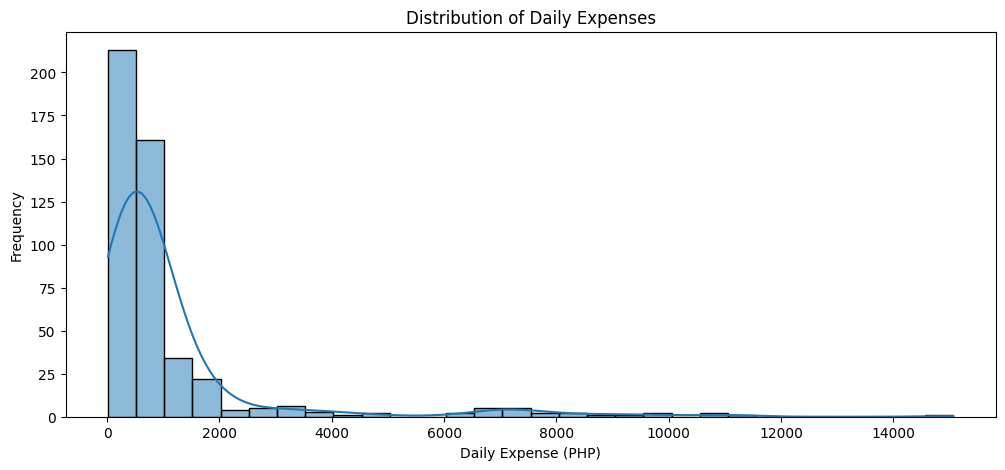

Skewness (Daily_Expense): 3.8119
Kurtosis (Daily_Expense): 16.1362


In [723]:
import seaborn as sns
from scipy.stats import skew, kurtosis

x = daily_expense["Daily_Expense"].dropna().astype(float)

plt.figure()
sns.histplot(x, bins=30, kde=True, stat="count")
plt.title("Distribution of Daily Expenses")
plt.xlabel("Daily Expense (PHP)")
plt.ylabel("Frequency")
plt.show()

# Distribution shape stats
skewness = skew(x, bias=False)
kurt = kurtosis(x, fisher=True, bias=False)

print(f"Skewness (Daily_Expense): {skewness:.4f}")
print(f"Kurtosis (Daily_Expense): {kurt:.4f}")

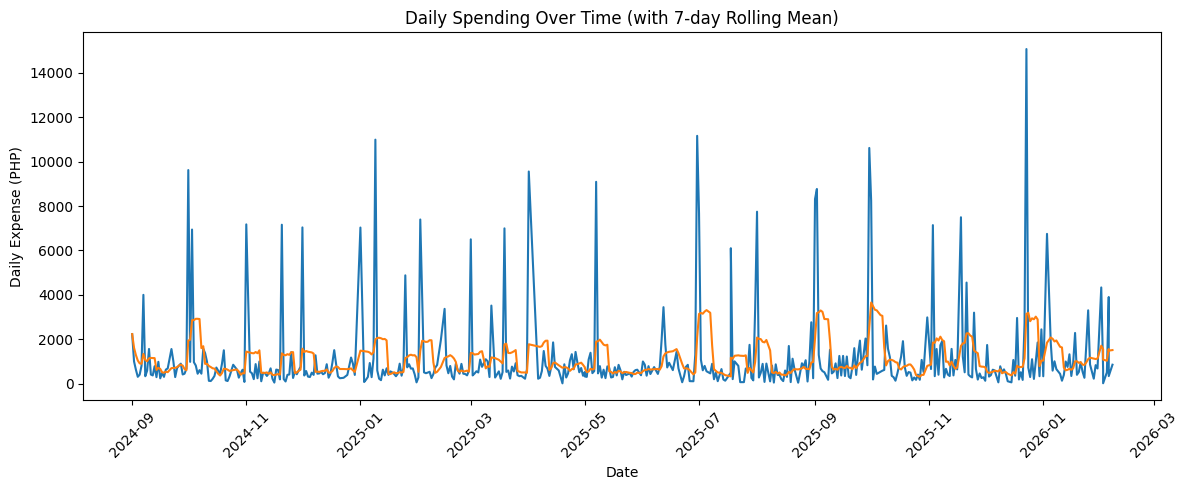

In [724]:
daily_expense_sorted = daily_expense.sort_values("Expenses_Date").copy()

daily_expense_sorted["Rolling7"] = daily_expense_sorted["Daily_Expense"].rolling(7, min_periods=1).mean()

plt.figure()
plt.plot(daily_expense_sorted["Expenses_Date"], daily_expense_sorted["Daily_Expense"])
plt.plot(daily_expense_sorted["Expenses_Date"], daily_expense_sorted["Rolling7"])
plt.title("Daily Spending Over Time (with 7-day Rolling Mean)")
plt.xlabel("Date")
plt.ylabel("Daily Expense (PHP)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [725]:
daytype_stats = (
    daily_expense
    .groupby("Day_Type", as_index=False)
    .agg(
        Mean=("Daily_Expense","mean"),
        Median=("Daily_Expense","median"),
        SD=("Daily_Expense","std"),
        Days=("Daily_Expense","size")
    )
    .sort_values("Mean", ascending=False)
)

daytype_stats

,Day_Type,Mean,Median,SD,Days
0,Regular,1360.131387,655.0,2226.952986,137
1,School,1038.978541,559.0,1779.672910,233
2,Weekend,1004.923810,540.0,1460.167454,105


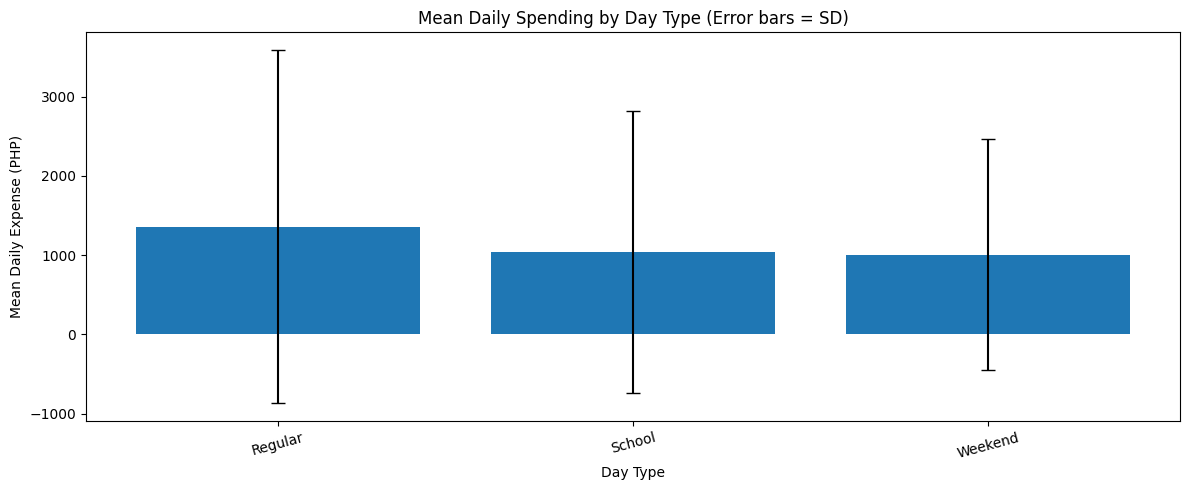

In [726]:
daytype_stats_plot = daytype_stats.copy()

plt.figure()
plt.bar(daytype_stats_plot["Day_Type"], daytype_stats_plot["Mean"], yerr=daytype_stats_plot["SD"], capsize=5)
plt.title("Mean Daily Spending by Day Type (Error bars = SD)")
plt.xlabel("Day Type")
plt.ylabel("Mean Daily Expense (PHP)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [727]:
dow_stats = (
    daily_expense
    .groupby("Day_of_Week", as_index=False)
    .agg(Mean=("Daily_Expense","mean"), Median=("Daily_Expense","median"), SD=("Daily_Expense","std"), Days=("Daily_Expense","size"))
    .sort_values("Day_of_Week")
)

dow_stats

/tmp/ipython-input-1130529426.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("Day_of_Week", as_index=False)


,Day_of_Week,Mean,Median,SD,Days
0,Monday,1044.125000,526.0,1798.974786,72
1,Tuesday,1538.098592,570.0,2895.947800,71
2,Wednesday,1261.057143,677.5,1895.103231,70
3,Thursday,1044.000000,533.5,1647.834943,68
4,Friday,1002.363636,613.5,1488.346389,66
5,Saturday,963.354839,512.5,1389.265511,62
6,Sunday,975.833333,600.5,1330.787547,66


In [728]:
# CATEGORY TOTALS OVERALL
cat_overall = (
    df_expenses
    .groupby("Expenses_Category", as_index=False)
    .agg(Total=("Expenses_Amount","sum"))
    .sort_values("Total", ascending=False)
)

cat_overall["Percent_of_Total"] = 100 * cat_overall["Total"] / cat_overall["Total"].sum()
cat_overall

,Expenses_Category,Total,Percent_of_Total
0,Food,149173.0,27.938315
2,Personal,107406.0,20.115856
3,Rent,101834.0,19.072288
5,School,68755.0,12.876987
6,Transportation,39848.0,7.463053
7,Utilities,31563.0,5.911372
1,Loan,29385.0,5.503458
4,Savings,5973.0,1.118671


In [729]:
# CATEGORY BY DAY TYPE (total + % within day type)
cat_daytype = (
    df_expenses
    .groupby(["Day_Type","Expenses_Category"], as_index=False)
    .agg(Total=("Expenses_Amount","sum"))
)

daytype_totals = (
    df_expenses
    .groupby("Day_Type", as_index=False)
    .agg(DayType_Total=("Expenses_Amount","sum"))
)

cat_daytype = cat_daytype.merge(daytype_totals, on="Day_Type", how="left")
cat_daytype["Percent_within_DayType"] = 100 * cat_daytype["Total"] / cat_daytype["DayType_Total"]

cat_daytype.sort_values(["Day_Type","Total"], ascending=[True, False])

,Day_Type,Expenses_Category,Total,DayType_Total,Percent_within_DayType
0,Regular,Food,43333.0,186338.0,23.255053
2,Regular,Personal,37582.0,186338.0,20.168726
3,Regular,Rent,32500.0,186338.0,17.441424
1,Regular,Loan,23561.0,186338.0,12.644227
5,Regular,School,22216.0,186338.0,11.922421
6,Regular,Transportation,13245.0,186338.0,7.108051
7,Regular,Utilities,11928.0,186338.0,6.401271
4,Regular,Savings,1973.0,186338.0,1.058829
8,School,Food,76126.0,242082.0,31.446369
10,School,Personal,46114.0,242082.0,19.048917


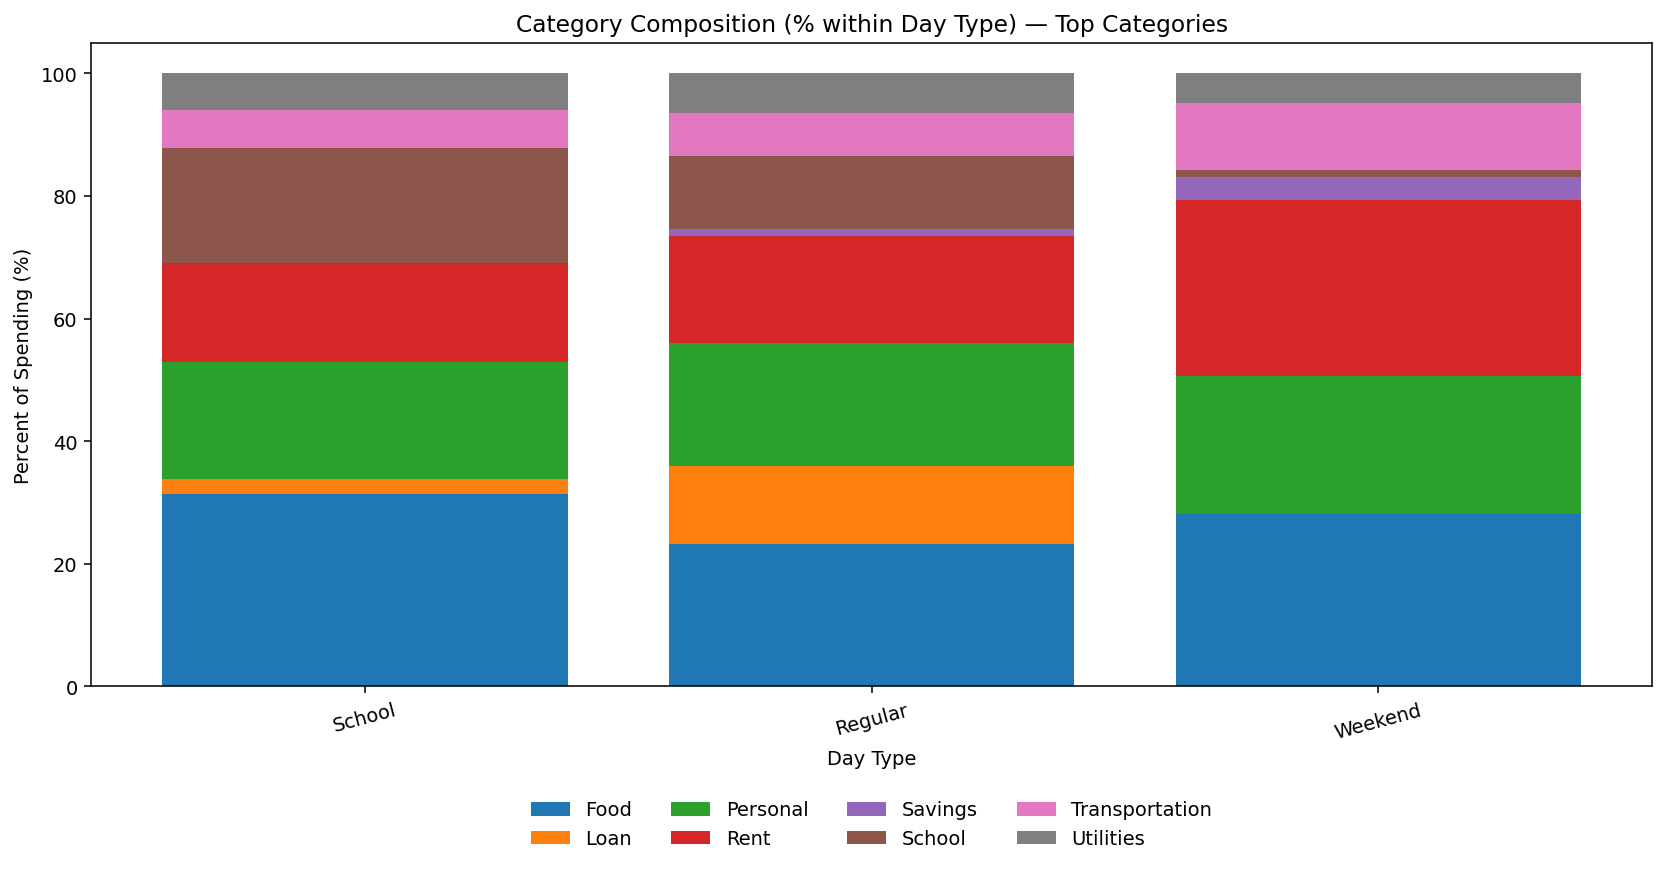

In [744]:
# Stacked Bar of category % by day type (top categories)
top_cats = cat_overall["Expenses_Category"].head(8).tolist()

stack_df = cat_daytype[cat_daytype["Expenses_Category"].isin(top_cats)].copy()
pivot_pct = (
    stack_df.pivot_table(
        index="Day_Type",
        columns="Expenses_Category",
        values="Percent_within_DayType",
        aggfunc="sum"
    )
    .fillna(0)
)

pivot_pct = pivot_pct.loc[["School", "Regular", "Weekend"]]

# Bigger scale (bigger canvas + sharper render)
fig, ax = plt.subplots(figsize=(12, 7), dpi=140)

bottom = np.zeros(len(pivot_pct))
for col in pivot_pct.columns:
    ax.bar(pivot_pct.index, pivot_pct[col].values, bottom=bottom, label=col)
    bottom += pivot_pct[col].values

ax.set_title("Category Composition (% within Day Type) — Top Categories")
ax.set_xlabel("Day Type")
ax.set_ylabel("Percent of Spending (%)")
ax.tick_params(axis="x", rotation=15)

# Legend below (centered, horizontal layout)
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=4,              # adjust depending on how many categories you want per row
    frameon=False
)

# Leave room at the bottom for the legend
fig.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()


In [731]:
# INCOME CLEANUP: focus categories
df_income["Income_Category"] = df_income["Income_Category"].astype(str).str.strip()

# Mark baseline + shock
df_income["Is_School_Allowance"] = df_income["Income_Category"].str.contains("School Allowance", case=False, na=False)
df_income["Is_Scholarship"]      = df_income["Income_Category"].str.contains("Scholarship Allowance", case=False, na=False)

# Create income-per-day totals
daily_income = (
    df_income
    .groupby("Income_Date", as_index=False)
    .agg(
        Daily_Income=("Income_Amount","sum"),
        Scholarship_Income=("Income_Amount", lambda x: x[df_income.loc[x.index,"Is_Scholarship"]].sum()),
        School_Allowance_Income=("Income_Amount", lambda x: x[df_income.loc[x.index,"Is_School_Allowance"]].sum())
    )
)

daily_income["Scholarship_Received"] = (daily_income["Scholarship_Income"] > 0).astype(int)
daily_income = daily_income.sort_values("Income_Date")
daily_income.head()

,Income_Date,Daily_Income,Scholarship_Income,School_Allowance_Income,Scholarship_Received
0,2024-09-01,4000.0,0.0,2000.0,0
1,2024-09-03,2000.0,2000.0,0.0,1
2,2024-09-07,5000.0,5000.0,0.0,1
3,2024-09-08,200.0,0.0,0.0,0
4,2024-09-10,1700.0,1000.0,200.0,1


In [732]:
# Merge daily expense + income indicators by date
daily = daily_expense_sorted.merge(
    daily_income[["Income_Date","Daily_Income","Scholarship_Income","School_Allowance_Income","Scholarship_Received"]],
    left_on="Expenses_Date", right_on="Income_Date", how="left"
)

daily = daily.drop(columns=["Income_Date"])
daily[["Daily_Income","Scholarship_Income","School_Allowance_Income","Scholarship_Received"]] = daily[
    ["Daily_Income","Scholarship_Income","School_Allowance_Income","Scholarship_Received"]
].fillna(0)

daily.head()

,Expenses_Date,Day_Type,Daily_Expense,Expense_Entries,Day_of_Week,Is_Outlier,Rolling7,Daily_Income,Scholarship_Income,School_Allowance_Income,Scholarship_Received
0,2024-09-01,Weekend,2234.0,6,Sunday,True,2234.0,4000.0,0.0,2000.0,0.0
1,2024-09-02,School,1001.0,3,Monday,False,1617.5,0.0,0.0,0.0,0.0
2,2024-09-03,School,629.0,2,Tuesday,False,1288.0,2000.0,2000.0,0.0,1.0
3,2024-09-04,Regular,310.0,2,Wednesday,False,1043.5,0.0,0.0,0.0,0.0
4,2024-09-05,School,404.0,1,Thursday,False,915.6,0.0,0.0,0.0,0.0


# Question 1: Is there a statistically significant difference in mean daily spending across school days, regular days, and weekends?

Statistical Test: ANOVA

- Ho: There is no statistically significant difference in mean daily spending among school days, regular days, and weekends.
- Ha: There is a significantly different mean daily spending among school days, regular days, and weekends.

In [733]:
# ANOVA: Day_Type differences
alpha = 0.05

anova_df = daily_expense.dropna(subset=["Daily_Expense", "Day_Type"]).copy()

# Groups
groups = {
    "School":  anova_df.loc[anova_df["Day_Type"] == "School", "Daily_Expense"].values,
    "Regular": anova_df.loc[anova_df["Day_Type"] == "Regular", "Daily_Expense"].values,
    "Weekend": anova_df.loc[anova_df["Day_Type"] == "Weekend", "Daily_Expense"].values,
}

# Assumption check: homogeneity of variance
levene_stat, levene_p = stats.levene(groups["School"], groups["Regular"], groups["Weekend"], center="median")

# One-way ANOVA
F_stat, p_anova = stats.f_oneway(groups["School"], groups["Regular"], groups["Weekend"])

# Effect size: eta-squared
grand_mean = anova_df["Daily_Expense"].mean()
ss_between = sum(len(v) * (np.mean(v) - grand_mean) ** 2 for v in groups.values())
ss_total = np.sum((anova_df["Daily_Expense"] - grand_mean) ** 2)
eta_sq = ss_between / ss_total if ss_total != 0 else np.nan

# Nonparametric backup (good for skew/outliers): Kruskal–Wallis
H_stat, p_kw = stats.kruskal(groups["School"], groups["Regular"], groups["Weekend"])

# Decisions
decision_anova = "Reject H0" if p_anova < alpha else "Fail to Reject H0"
decision_kw    = "Reject H0" if p_kw < alpha else "Fail to Reject H0"

# Build a clean table (rubric-friendly)
anova_results_table = pd.DataFrame([
    {
        "Test": "Levene (median-centered)",
        "Purpose": "Variance equality check",
        "Statistic": levene_stat,
        "p-value": levene_p,
        "alpha": alpha,
        "Decision": "Equal variances plausible" if levene_p >= alpha else "Variances differ (use robust/NP)"
    },
    {
        "Test": "One-way ANOVA",
        "Purpose": "Mean Daily_Expense differs by Day_Type",
        "Statistic": F_stat,
        "p-value": p_anova,
        "alpha": alpha,
        "Decision": decision_anova,
        "Effect Size (eta²)": eta_sq
    },
    {
        "Test": "Kruskal–Wallis",
        "Purpose": "Distribution differs by Day_Type (nonparametric)",
        "Statistic": H_stat,
        "p-value": p_kw,
        "alpha": alpha,
        "Decision": decision_kw
    }
])

display(
    anova_results_table.style.format({
        "Statistic": "{:.4f}",
        "p-value": "{:.6f}",
        "alpha": "{:.2f}",
        "Effect Size (eta²)": "{:.4f}"
    })
)

,Test,Purpose,Statistic,p-value,alpha,Decision,Effect Size (eta²)
0,Levene (median-centered),Variance equality check,1.4302,0.240307,0.05,Equal variances plausible,nan
1,One-way ANOVA,Mean Daily_Expense differs by Day_Type,1.5644,0.210287,0.05,Fail to Reject H0,0.0066
2,Kruskal–Wallis,Distribution differs by Day_Type (nonparametric),3.1320,0.208883,0.05,Fail to Reject H0,nan


# Question 2: Does daily spending change significantly after a sudden additional income is received?

Statistical Test: Paired T-Test

- Ho: There is no significant difference in mean daily spending before and after income receipt.
- Ha: Mean daily spending increases significantly following income receipt.

In [734]:
# BUILD BEFORE/AFTER WINDOWS (3-day)
shock_dates = daily.loc[daily["Scholarship_Received"] == 1, "Expenses_Date"].sort_values().unique()

pairs = []
window = 3

for d in shock_dates:
    before_mask = (daily["Expenses_Date"] >= (d - pd.Timedelta(days=window))) & (daily["Expenses_Date"] < d)
    after_mask  = (daily["Expenses_Date"] > d) & (daily["Expenses_Date"] <= (d + pd.Timedelta(days=window)))

    before_mean = daily.loc[before_mask, "Daily_Expense"].mean()
    after_mean  = daily.loc[after_mask, "Daily_Expense"].mean()

    if pd.notna(before_mean) and pd.notna(after_mean):
        pairs.append([pd.to_datetime(d), before_mean, after_mean])

pairs_df = pd.DataFrame(pairs, columns=["Shock_Date","Mean_Before_3d","Mean_After_3d"])
pairs_df

,Shock_Date,Mean_Before_3d,Mean_After_3d
0,2024-09-03,1617.500000,507.000000
1,2024-09-07,507.000000,829.000000
2,2024-09-10,1641.000000,524.333333
3,2024-09-13,782.333333,507.000000
4,2024-09-17,507.000000,543.000000
5,2024-09-18,572.333333,660.500000
6,2024-09-19,346.666667,1124.500000
7,2024-09-22,660.500000,674.666667
8,2024-09-26,674.666667,589.000000
9,2024-10-01,514.000000,2963.000000


In [735]:
alpha = 0.05

# Safety: ensure enough events
if len(pairs_df) >= 5:
    before = pairs_df["Mean_Before_3d"].astype(float)
    after  = pairs_df["Mean_After_3d"].astype(float)

    diff = after - before
    mean_diff = diff.mean()

    # Paired t-test
    t_stat, p_t = stats.ttest_rel(after, before)

    # Effect size (paired): Cohen's d using diff SD
    d = mean_diff / diff.std(ddof=1) if diff.std(ddof=1) != 0 else np.nan

    # Nonparametric backup: Wilcoxon signed-rank (on differences)
    # Note: Wilcoxon requires non-zero diffs; handle edge-case
    nonzero_diff = diff[diff != 0]
    if len(nonzero_diff) >= 5:
        w_stat, p_w = stats.wilcoxon(nonzero_diff)
    else:
        w_stat, p_w = np.nan, np.nan

    # Bootstrap 95% CI for mean difference (After - Before)
    rng = np.random.default_rng(42)
    boots = [rng.choice(diff.values, size=len(diff), replace=True).mean() for _ in range(5000)]
    ci_low, ci_high = np.percentile(boots, [2.5, 97.5])

    # Decisions
    decision_t = "Reject H0" if p_t < alpha else "Fail to Reject H0"
    decision_w = ("Reject H0" if (pd.notna(p_w) and p_w < alpha) else
                  "Fail to Reject H0" if pd.notna(p_w) else
                  "Not computed (insufficient non-zero diffs)")

    paired_results_table = pd.DataFrame([
        {
            "Test": "Paired t-test",
            "Purpose": "Mean spending changes after scholarship receipt",
            "n (events)": len(pairs_df),
            "Statistic": t_stat,
            "p-value": p_t,
            "alpha": alpha,
            "Decision": decision_t,
            "Mean Diff (After - Before)": mean_diff,
            "Cohen's d": d,
            "Boot CI 2.5%": ci_low,
            "Boot CI 97.5%": ci_high
        },
        {
            "Test": "Wilcoxon signed-rank",
            "Purpose": "Median change after scholarship (nonparametric)",
            "n (events)": len(pairs_df),
            "Statistic": w_stat,
            "p-value": p_w,
            "alpha": alpha,
            "Decision": decision_w,
            "Median Diff (After - Before)": diff.median()
        }
    ])

    display(
        paired_results_table.style.format({
            "Statistic": "{:.4f}",
            "p-value": "{:.6f}",
            "alpha": "{:.2f}",
            "Mean Diff (After - Before)": "{:.2f}",
            "Cohen's d": "{:.4f}",
            "Boot CI 2.5%": "{:.2f}",
            "Boot CI 97.5%": "{:.2f}",
            "Median Diff (After - Before)": "{:.2f}",
        })
    )

else:
    display(pd.DataFrame([{
        "Test": "Paired analysis",
        "n (events)": len(pairs_df),
        "Decision": "Not enough scholarship events to run paired tests reliably (recommend >= 5)."
    }]))

,Test,Purpose,n (events),Statistic,p-value,alpha,Decision,Mean Diff (After - Before),Cohen's d,Boot CI 2.5%,Boot CI 97.5%,Median Diff (After - Before)
0,Paired t-test,Mean spending changes after scholarship receipt,54,-0.6908,0.492683,0.05,Fail to Reject H0,-143.82,-0.0940,-559.73,265.65,nan
1,Wilcoxon signed-rank,Median change after scholarship (nonparametric),54,742.0000,0.996565,0.05,Fail to Reject H0,nan,nan,nan,nan,83.83


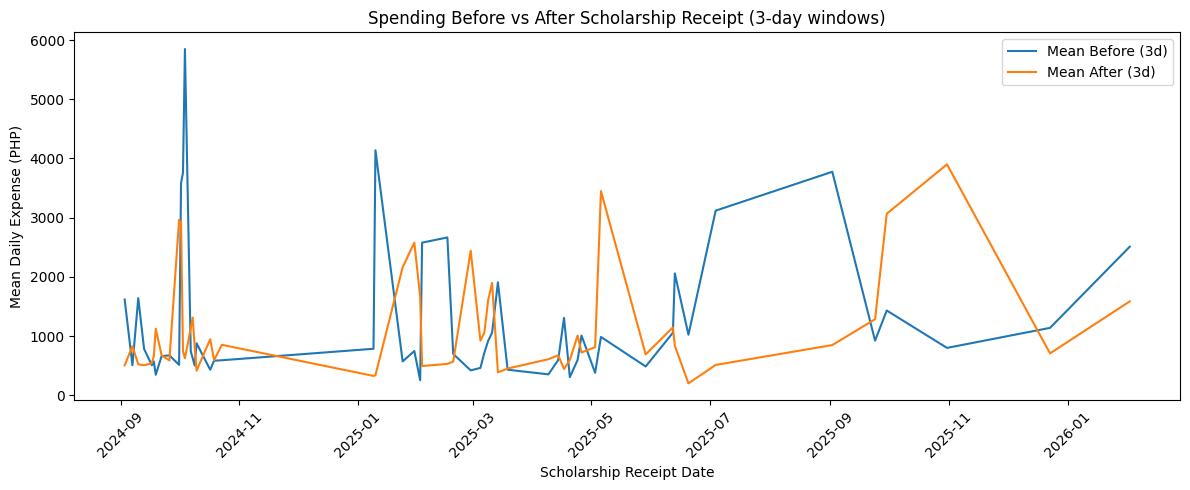

In [736]:
# Before vs After plot
if len(pairs_df) >= 1:
    plt.figure()
    plt.plot(pairs_df["Shock_Date"], pairs_df["Mean_Before_3d"], label="Mean Before (3d)")
    plt.plot(pairs_df["Shock_Date"], pairs_df["Mean_After_3d"], label="Mean After (3d)")
    plt.title("Spending Before vs After Scholarship Receipt (3-day windows)")
    plt.xlabel("Scholarship Receipt Date")
    plt.ylabel("Mean Daily Expense (PHP)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()

In [737]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)


# WEEKLY EXPENSE-INCOME RATIO
daily["Year"] = daily["Expenses_Date"].dt.isocalendar().year.astype(int)
daily["Week"] = daily["Expenses_Date"].dt.isocalendar().week.astype(int)

weekly_exp = (
    daily
    .groupby(["Year","Week"], as_index=False)
    .agg(Weekly_Expense=("Daily_Expense","sum"))
)

# Weekly income from income table (same ISO week)
df_income["Year"] = df_income["Income_Date"].dt.isocalendar().year.astype(int)
df_income["Week"] = df_income["Income_Date"].dt.isocalendar().week.astype(int)

weekly_inc = (
    df_income
    .groupby(["Year","Week"], as_index=False)
    .agg(Weekly_Income=("Income_Amount","sum"))
)

weekly = weekly_exp.merge(weekly_inc, on=["Year","Week"], how="left")
weekly["Weekly_Income"] = weekly["Weekly_Income"].fillna(0)

weekly["Expense_Income_Ratio"] = np.where(weekly["Weekly_Income"] > 0,
                                         weekly["Weekly_Expense"] / weekly["Weekly_Income"],
                                         np.nan)

weekly

,Year,Week,Weekly_Expense,Weekly_Income,Expense_Income_Ratio
0,2024,35,2234.0,4000.0,0.558500
1,2024,36,7486.0,7200.0,1.039722
2,2024,37,5005.0,4200.0,1.191667
3,2024,38,3923.0,5150.0,0.761748
4,2024,39,4605.0,3300.0,1.395455
5,2024,40,20453.0,20562.0,0.994699
6,2024,41,5252.0,5700.0,0.921404
7,2024,42,4720.0,4100.0,1.151220
8,2024,43,2075.0,2700.0,0.768519
9,2024,44,9170.0,10270.0,0.892892


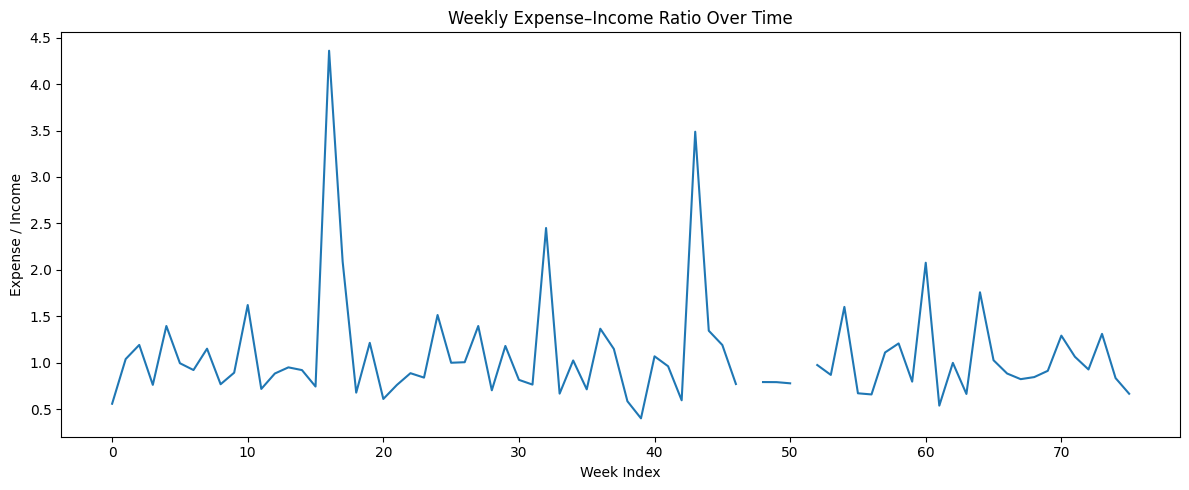

In [738]:
plt.figure()
plt.plot(weekly.index, weekly["Expense_Income_Ratio"])
plt.title("Weekly Expense–Income Ratio Over Time")
plt.xlabel("Week Index")
plt.ylabel("Expense / Income")
plt.tight_layout()
plt.show()

In [739]:
daily_corr = daily.copy()

# Day-type dummies (drop one to avoid redundancy)
daily_corr["Is_Weekend"]   = (daily_corr["Day_Type"] == "Weekend").astype(int)
daily_corr["Is_SchoolDay"] = (daily_corr["Day_Type"] == "School").astype(int)
daily_corr["Is_RegularDay"] = (daily_corr["Day_Type"] == "Regular").astype(int)

# Day-of-week + month markers
daily_corr["DayOfWeek"] = pd.to_datetime(daily_corr["Expenses_Date"]).dt.dayofweek  # 0=Mon
daily_corr["Is_MonthStart"] = pd.to_datetime(daily_corr["Expenses_Date"]).dt.day <= 5
daily_corr["Is_MonthEnd"]   = pd.to_datetime(daily_corr["Expenses_Date"]).dt.days_in_month - pd.to_datetime(daily_corr["Expenses_Date"]).dt.day < 5
daily_corr["Is_MonthStart"] = daily_corr["Is_MonthStart"].astype(int)
daily_corr["Is_MonthEnd"]   = daily_corr["Is_MonthEnd"].astype(int)

# Days since last income
income_dates = df_income["Income_Date"].sort_values().unique()

def days_since_last_income(d):
    past = income_dates[income_dates <= np.datetime64(d)]
    if len(past) == 0:
        return np.nan
    return (pd.to_datetime(d) - pd.to_datetime(past[-1])).days

daily_corr["Days_Since_Last_Income"] = daily_corr["Expenses_Date"].apply(days_since_last_income)

# Volatility features
daily_corr = daily_corr.sort_values("Expenses_Date")
daily_corr["Expense_Change"] = daily_corr["Daily_Expense"].diff()
daily_corr["RollingMean_7d"] = daily_corr["Daily_Expense"].rolling(7, min_periods=3).mean()
daily_corr["RollingSD_7d"]   = daily_corr["Daily_Expense"].rolling(7, min_periods=3).std()

# Log transform for stability
daily_corr["Log_Daily_Expense"] = np.log1p(daily_corr["Daily_Expense"])

corr_vars = [
    "Daily_Expense",
    "Log_Daily_Expense",
    "Scholarship_Received",
    "Days_Since_Last_Income",
    "Is_Weekend",
    "Is_SchoolDay",
    "Is_RegularDay",
    "DayOfWeek",
    "Is_MonthStart",
    "Is_MonthEnd",
    "Week",
    "Expense_Change",
    "RollingMean_7d",
    "RollingSD_7d"
]

corr_df = daily_corr[corr_vars].dropna()
corr_matrix = corr_df.corr(numeric_only=True)
corr_matrix

,Daily_Expense,Log_Daily_Expense,Scholarship_Received,Days_Since_Last_Income,Is_Weekend,Is_SchoolDay,Is_RegularDay,DayOfWeek,Is_MonthStart,Is_MonthEnd,Week,Expense_Change,RollingMean_7d,RollingSD_7d
Daily_Expense,1.000000,0.786971,0.230630,-0.222221,-0.036740,-0.043647,0.081650,-0.063746,0.226267,-0.029117,-0.018387,0.667078,0.335003,0.334569
Log_Daily_Expense,0.786971,1.000000,0.226090,-0.247911,-0.056760,-0.035040,0.090444,-0.043357,0.154026,-0.022433,-0.054163,0.532214,0.279890,0.225570
Scholarship_Received,0.230630,0.226090,1.000000,-0.306319,-0.049254,0.013500,0.030094,-0.017654,0.065055,-0.032995,-0.087723,0.095059,0.109502,0.077248
Days_Since_Last_Income,-0.222221,-0.247911,-0.306319,1.000000,-0.132515,0.152574,-0.047159,0.013683,-0.107951,0.013775,0.085351,-0.042191,-0.143662,-0.127725
Is_Weekend,-0.036740,-0.056760,-0.049254,-0.132515,1.000000,-0.520882,-0.338996,0.719883,-0.008032,0.017927,-0.049176,-0.002936,-0.051689,-0.034630
Is_SchoolDay,-0.043647,-0.035040,0.013500,0.152574,-0.520882,1.000000,-0.626507,-0.294991,-0.025258,-0.026222,-0.000988,-0.033389,-0.027920,-0.026675
Is_RegularDay,0.081650,0.090444,0.030094,-0.047159,-0.338996,-0.626507,1.000000,-0.332187,0.035171,0.012531,0.045989,0.039478,0.077966,0.061018
DayOfWeek,-0.063746,-0.043357,-0.017654,0.013683,0.719883,-0.294991,-0.332187,1.000000,-0.040176,0.009874,0.002357,-0.044557,-0.033655,-0.033001
Is_MonthStart,0.226267,0.154026,0.065055,-0.107951,-0.008032,-0.025258,0.035171,-0.040176,1.000000,-0.197406,-0.062271,-0.039090,0.359278,0.317628
Is_MonthEnd,-0.029117,-0.022433,-0.032995,0.013775,0.017927,-0.026222,0.012531,0.009874,-0.197406,1.000000,0.011624,0.046439,-0.147679,-0.150559


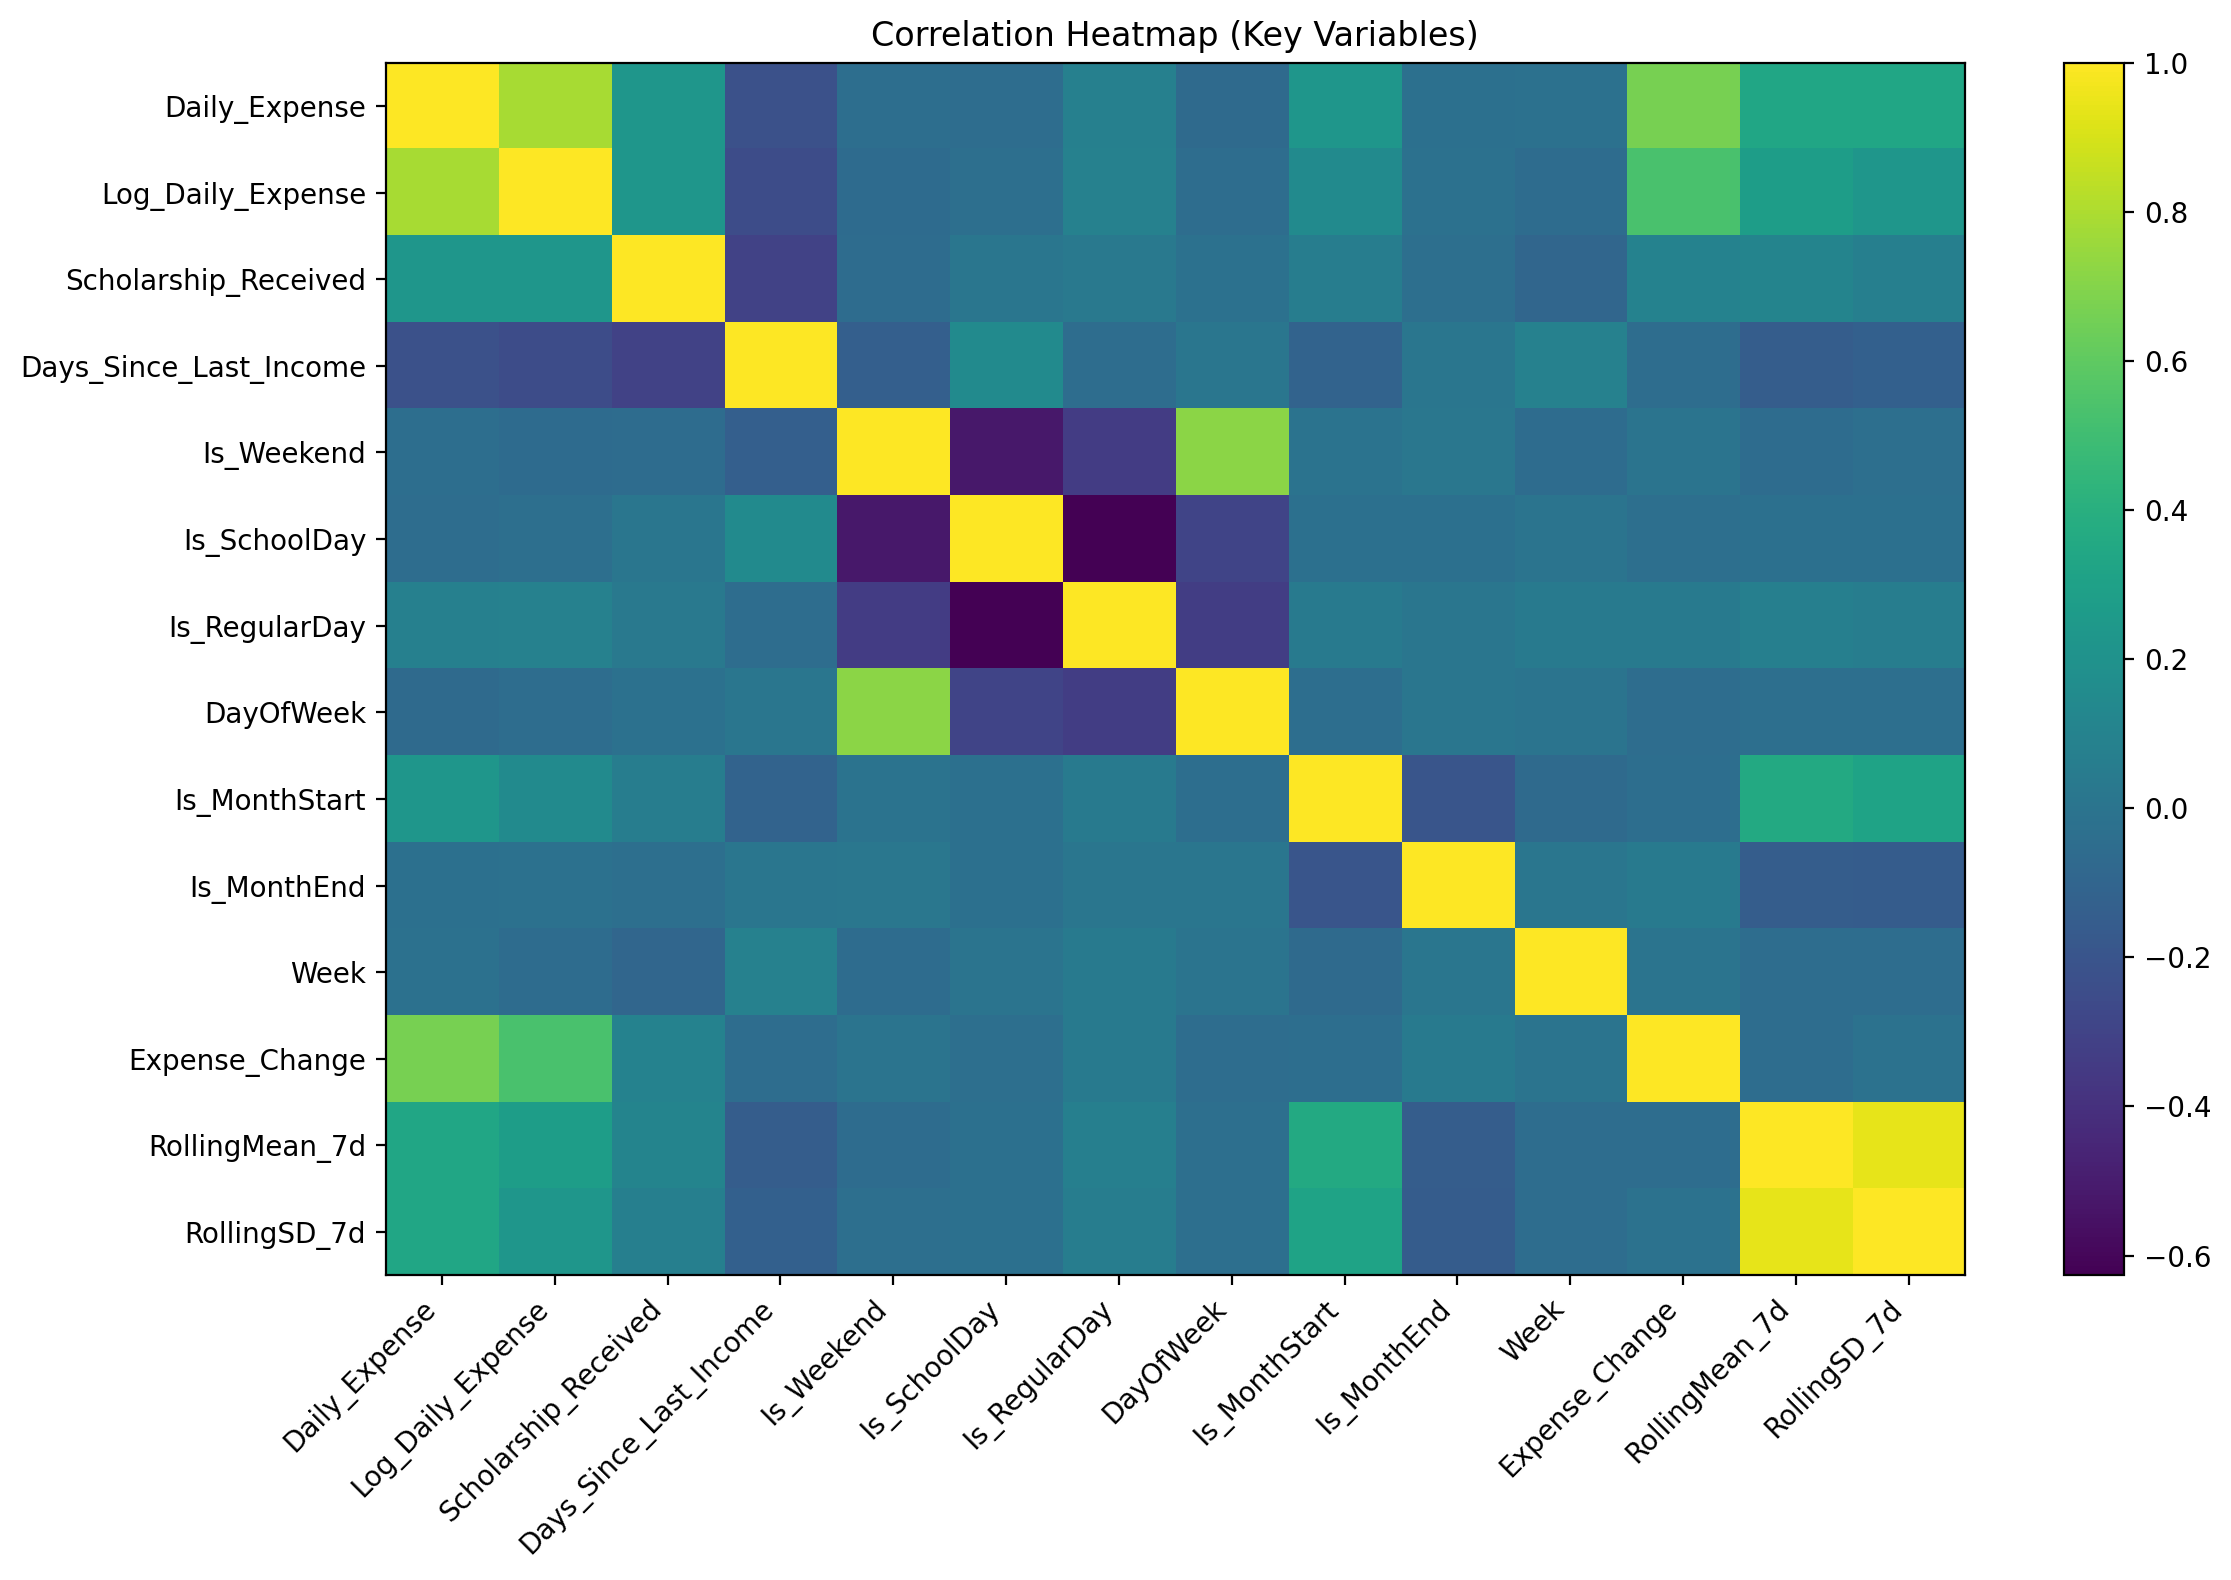

In [746]:
plt.figure(figsize=(12, 8), dpi=200)
im = plt.imshow(corr_matrix, aspect="auto", interpolation="nearest")
plt.title("Correlation Heatmap (Key Variables)")
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45, ha="right")
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.colorbar(im)
plt.tight_layout()
plt.savefig("FIG_HEATMAP.png", dpi=300, bbox_inches="tight")
plt.show()

In [741]:
# REGRESSION MODEL
# Outcome: Daily_Expense
# Predictors:
#   - C(Day_Type): answers RQ1 (School/Weekend vs Regular baseline)
#   - PostScholarship_7d: answers RQ2 (0–7 days after income receipt)
#   - t (time trend): controls gradual drift over the study period
# SEs: HAC(7) for longitudinal autocorrelation

import statsmodels.formula.api as smf

# Prep (ensure sorted dates + clean Day_Type)
df = daily_corr.copy()
df["Expenses_Date"] = pd.to_datetime(df["Expenses_Date"])
df = df.sort_values("Expenses_Date")

df["Day_Type"] = pd.Categorical(
    df["Day_Type"],
    categories=["Regular", "School", "Weekend"],  # Regular = baseline
    ordered=False
)

# Build "post-income window" feature (0–3 days after scholarship receipt)
scholarship_dates = pd.to_datetime(
    daily_income.loc[daily_income["Scholarship_Received"] == 1, "Income_Date"]
).sort_values().unique()

def days_since_last_event(date, event_dates):
    past = event_dates[event_dates <= np.datetime64(date)]
    if len(past) == 0:
        return np.nan
    return (pd.to_datetime(date) - pd.to_datetime(past[-1])).days

df["Days_Since_Scholarship"] = df["Expenses_Date"].apply(
    lambda d: days_since_last_event(d, scholarship_dates)
)

df["PostScholarship_3d"] = df["Days_Since_Scholarship"].between(0, 3, inclusive="both").astype(int)

# ---- Time trend ----
df["t"] = (df["Expenses_Date"] - df["Expenses_Date"].min()).dt.days

# ---- Fit model ----
df_reg = df.dropna(subset=["Daily_Expense", "Day_Type", "PostScholarship_3d", "t"]).copy()

model = smf.ols(
    "Daily_Expense ~ C(Day_Type) + PostScholarship_3d + t",
    data=df_reg
).fit(cov_type="HAC", cov_kwds={"maxlags": 3})

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Daily_Expense   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     2.536
Date:                Wed, 18 Feb 2026   Prob (F-statistic):             0.0395
Time:                        01:41:47   Log-Likelihood:                -4241.8
No. Observations:                 475   AIC:                             8494.
Df Residuals:                     470   BIC:                             8514.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                840

In [743]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

BASE_OUTPUT = "analysis_results"
TABLE_DIR   = os.path.join(BASE_OUTPUT, "tables")
FIG_DIR     = os.path.join(BASE_OUTPUT, "figures")
MODEL_DIR   = os.path.join(BASE_OUTPUT, "models")

os.makedirs(TABLE_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# ----------------------------
# Save model summaries
# ----------------------------
with open(os.path.join(MODEL_DIR, "ols_summary.txt"), "w") as f:
    f.write(model.summary().as_text())

with open(os.path.join(MODEL_DIR, "ols_hc3_summary.txt"), "w") as f:
    f.write(model_hc3.summary().as_text())

# If you have the log model too, save it (safe if exists)
try:
    with open(os.path.join(MODEL_DIR, "ols_log1p_hc3_summary.txt"), "w") as f:
        f.write(model_log.summary().as_text())
except NameError:
    pass

# ----------------------------
# Save analysis dataset + tables
# ----------------------------
daily_expense.to_csv(os.path.join(TABLE_DIR, "daily_analysis_dataset.csv"), index=False)

anova_results_table.to_csv(os.path.join(TABLE_DIR, "anova_hypothesis_test_table.csv"), index=False)
paired_results_table.to_csv(os.path.join(TABLE_DIR, "paired_income_shock_test_table.csv"), index=False)

# ----------------------------
# Save regression figures
# Assumes you already created:
# reg, X, model_hc3 (and optionally model_log)
# ----------------------------
def save_fig(filename, dpi=300):
    plt.savefig(os.path.join(FIG_DIR, filename), dpi=dpi, bbox_inches="tight")
    plt.close()

save_fig("reg_coef_hc3_ci.png")
save_fig("reg_pred_vs_actual.png")
save_fig("reg_residuals_vs_fitted.png")
save_fig("reg_log1p_pred_vs_actual.png")

print("Saved outputs to:", BASE_OUTPUT)
print("Tables:", TABLE_DIR)
print("Figures:", FIG_DIR)
print("Models:", MODEL_DIR)

Saved outputs to: analysis_results
Tables: analysis_results/tables
Figures: analysis_results/figures
Models: analysis_results/models
